In [39]:
from tqdm import tqdm
import numpy as np
from lmfit import minimize, Parameters, fit_report, Model
import pickle
import os
from pyne2001 import get_dm_full
import json
import corner
import sys
import pywt

from astropy.coordinates import SkyCoord
from astropy.cosmology import FlatLambdaCDM, Planck15
import astropy.units as u

from scipy.signal import savgol_filter, resample, correlate, fftconvolve
import scipy
from scipy.fft import fft2, fftshift

import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.colors import LogNorm
from matplotlib.ticker import ScalarFormatter
import matplotlib.patches as patches

import importlib

rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['cmr10']
rcParams['font.size'] = 27
rcParams['axes.formatter.use_mathtext'] = True
rcParams['axes.unicode_minus'] = False
rcParams['mathtext.fontset'] = 'cm'
rcParams['text.usetex'] = False

sys.path.insert(0,'/arc/home/jfaber/baseband_morphologies/chime_dsa_codetections/scattering/')

import utilities.scinttools as sct
import utilities.burstfittools as bft

import warnings
warnings.filterwarnings("ignore")


In [40]:
def bandpasscorr_first(initrow, off_pulse_indices_time):
    #Effective bandpass correction
    row = (initrow - np.nanmean(initrow[off_pulse_indices_time])) / np.nanstd(initrow[off_pulse_indices_time])
    return row


def bandpasscorr_sec(arr, off_pulse_indices_time):
    arr = [bandpasscorr_first(row, off_pulse_indices_time) for row in arr]
    arr = np.asarray(arr)
    arr = np.nan_to_num(arr)
    return arr

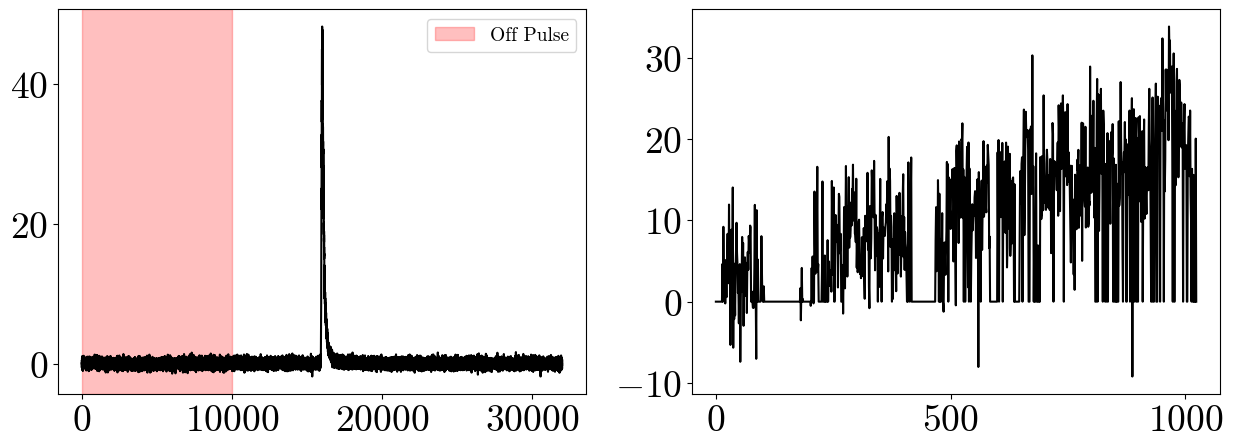

In [41]:
# Load data
name = 'casey'
basedir = '/arc/home/jfaber/baseband_morphologies/chime_dsa_codetections/data/CHIME_bursts/dmphase/'
npys = os.listdir(f'{basedir}')
npy = [i for i in npys if f'{name}' in i][0]
data = np.load(os.path.join(basedir, npy))
data = np.nan_to_num(data)

off_pulse_indices_time = np.arange(0, 10000)
#print(off_pulse_indices_time)
test_timeseries = np.nansum(data, axis = 0)
test_spectrum = np.nansum(data, axis=1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 5))
ax1.plot(test_timeseries, c='k')
ax1.axvspan(off_pulse_indices_time[0], off_pulse_indices_time[-1], alpha=0.25, color='r', label='Off Pulse')
ax1.legend(fontsize=14)
ax2.plot(test_spectrum, c='k')
plt.show()

# IF DEDISPERSING
#data = dedisperse(data, 0.0, fch1=1498.75, reffreq=1530., nf=6144, df=0.03051757812, nt=9500, dt=32.768e-3)

In [42]:
# IF SMOOTHING
#smoothing_kernel = 51
#smoothing_polyorder = 3
#data_smooth = savgol_filter(data_dd_lim_clean_IQUV[0, :, :], smoothing_kernel, smoothing_polyorder) #np.nanmean(data_dd_lim[:, 4000:7000]), 91, 3)
#savgol_filter(data_dd_lim, smoothing_kernel, smoothing_polyorder)

data_bpc = bandpasscorr_sec(data, off_pulse_indices_time)
offdata_bpc = data_bpc[:, off_pulse_indices_time]
data_bpc = data_bpc - np.nanmean(offdata_bpc)
data_bpc = data_bpc / np.nanstd(offdata_bpc)
data_bpc = data_bpc / np.max(data_bpc)
data_bpc = np.nan_to_num(data_bpc)

data_spectrum = np.nansum(data_bpc, axis=1)
offdata_spectrum = np.nansum(data_bpc[:, off_pulse_indices_time], axis=1)
data_spectrum = data_spectrum - np.nanmean(offdata_spectrum)
data_spectrum = data_spectrum / np.nanstd(offdata_spectrum)
data_spectrum = data_spectrum / np.max(data_spectrum)

data_timeseries = np.nansum(data_bpc, axis=0)
offdata_timeseries = np.nansum(data_bpc[:, off_pulse_indices_time], axis=0)
data_timeseries = data_timeseries - np.nanmean(offdata_timeseries)
data_timeseries = data_timeseries / np.nanstd(offdata_timeseries)
data_timeseries = data_timeseries / np.max(data_timeseries)
print('Smoothed & Cleaned Data Shape:', data_bpc.shape)

Smoothed & Cleaned Data Shape: (1024, 32000)


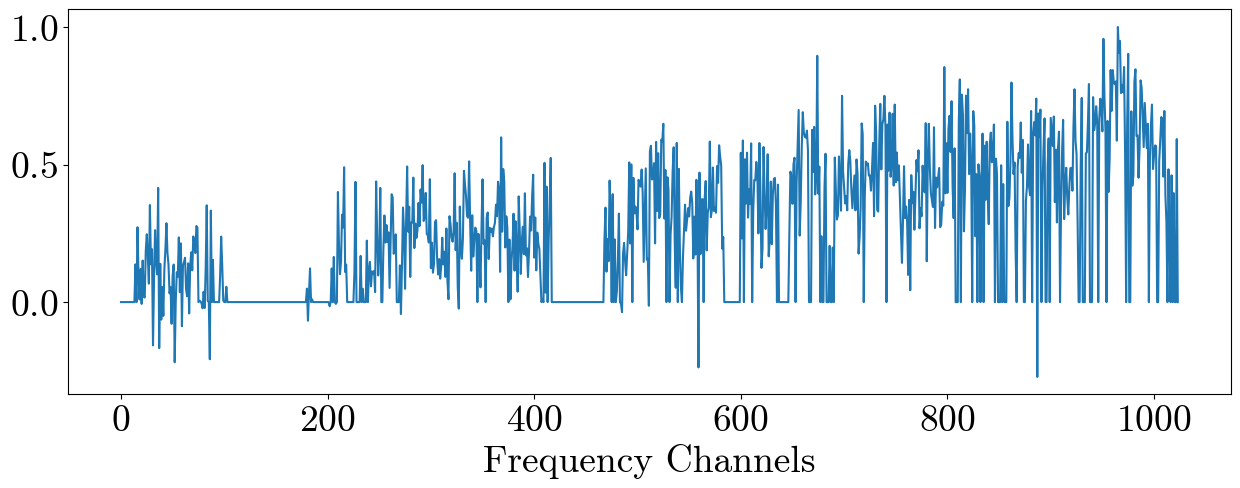

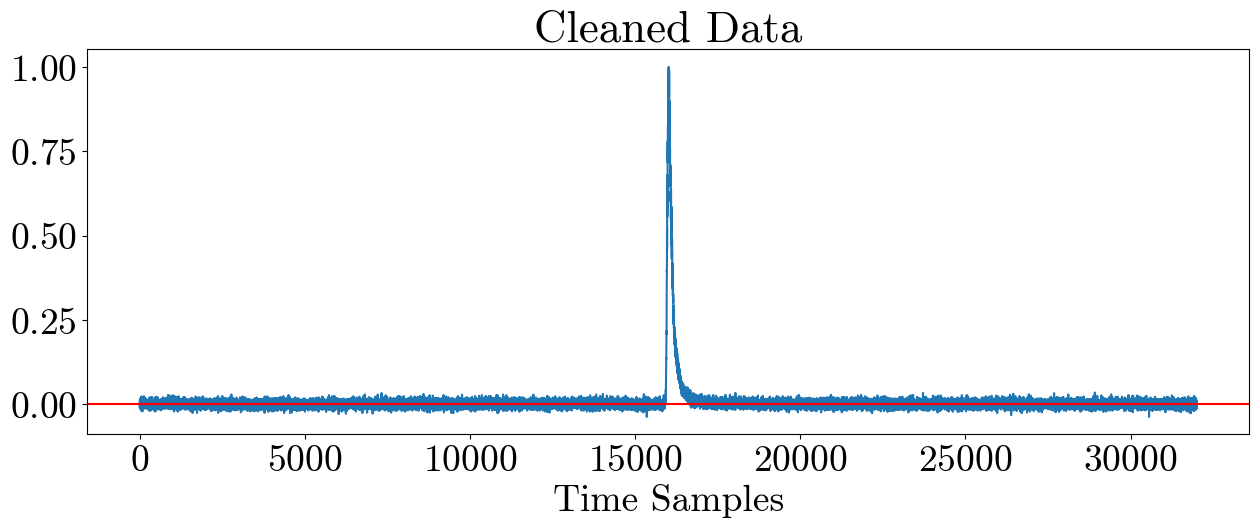

In [43]:
fig = plt.figure(figsize = (15, 5))
plt.plot(data_spectrum)
plt.xlabel('Frequency Channels')
plt.show()
fig = plt.figure(figsize = (15, 5))
plt.plot(data_timeseries)
plt.xlabel('Time Samples')
plt.axhline(0, c = 'r')
plt.title('Cleaned Data')
#plt.xlim(2500, 7500)
plt.show()

[<Axes: > <Axes: >]
[<Axes: > <Axes: >]


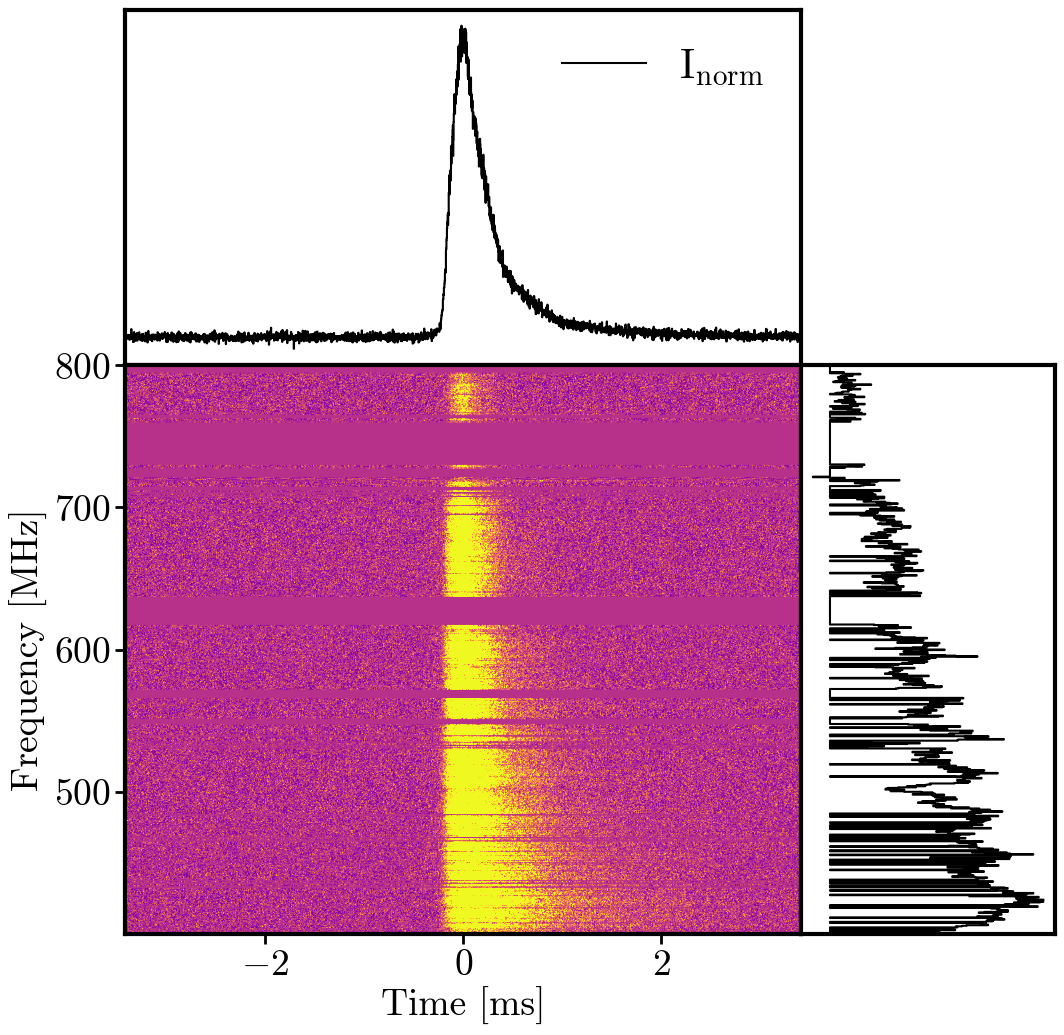

In [44]:
tres = 2.56e-3 #ms #data['delta_t (ms)']
fres = 0.390625 #MHz #data['delta_f (MHz)']
fres_kHz = fres*1e3
f_min = 400.19 #MHz, the addition is to account for the 100 channels that were removed from bottom of the band
f_max = 800.19 #MHz #data['fch1 (MHz)'] + data['df (MHz)']*data['nchans']

intensity = data_bpc #+ 3e-3 #data['I']
offintensity = intensity[:, off_pulse_indices_time]
offintensity_spectrum = np.nansum(intensity[:, off_pulse_indices_time], axis=1)
offintensity_timeseries = np.nansum(intensity[:, off_pulse_indices_time], axis=0)

outerbound = int(intensity.shape[1] * 5.5/12)

intensity = intensity[:, outerbound:-outerbound]

# Normalize intensity
intensity = intensity - np.nanmean(offintensity)
intensity = intensity / np.nanstd(offintensity)
intensity_norm = intensity / np.max(intensity)

# Normalized spectrum
intensity_spectrum = np.nansum(intensity, axis=1)
intensity_spectrum = intensity_spectrum - np.nanmean(offintensity_spectrum)
intensity_spectrum = intensity_spectrum / np.nanstd(offintensity_spectrum)
spectrum_norm = intensity_spectrum / np.max(intensity_spectrum)

# Channels
freqsamples = np.linspace(f_min, f_max, spectrum_norm.shape[0])

# Normalized timeseries
intensity_timeseries = np.nansum(intensity, axis=0)
intensity_timeseries = intensity_timeseries - np.nanmean(offintensity_timeseries)
intensity_timeseries = intensity_timeseries / np.nanstd(offintensity_timeseries)
timeseries_norm = intensity_timeseries / np.max(intensity_timeseries)

# Samples
timesamples = np.linspace(0, intensity.shape[1]*tres, intensity.shape[1])
timerange = np.abs(timesamples[-1] - timesamples[0])
timesamples_center = np.linspace(-timerange/2, timerange/2, len(timesamples))
timeshift = -1 * int(timesamples_center[np.argmax(savgol_filter(timeseries_norm, 11, 3))] / tres)

# Shift intensity to center
intensity_norm = np.roll(intensity, timeshift, axis = 1)
timeseries_norm = np.roll(timeseries_norm, timeshift)

#timeseries = np.nansum(intensity, axis=0)

#
#
#intensity_norm = intensity / np.nanmax(intensity)
#spectrum = np.nansum(intensity, axis = 1)
#spectrum_norm = spectrum / np.nanmax(spectrum)
#freqsamples = np.linspace(f_min, f_max, intensity.shape[0])
#timeseries = np.nansum(intensity, axis = 0)
#timeseries_norm = timeseries / np.nanmax(timeseries)


from matplotlib.colors import LogNorm

fig, axes = plt.subplots(
        nrows=2, ncols=2, sharex=False, sharey=False, 
        gridspec_kw={'height_ratios':[1.25,2], 'width_ratios':[2, 0.75]},
        figsize = (12, 12))

# Increase border thickness
current_axes = plt.gca()
for ax_row in axes:
    for ax in ax_row:
        ax.spines['top'].set_linewidth(3)
        ax.spines['bottom'].set_linewidth(3)
        ax.spines['left'].set_linewidth(3)
        ax.spines['right'].set_linewidth(3)
for ax_row in axes:
    print(ax_row)
    for ax in ax_row:
        ax.tick_params(which='both', width=2)
        ax.tick_params(which='major', length=7)
        ax.tick_params(which='minor', length=5)
        ax.tick_params(which='minor', axis = 'y', length=5)

axes[0, 0].step(timesamples_center, timeseries_norm, where = 'mid', c = 'k', alpha = 1, label = 'I$_{\mathrm{norm}}$')
#axes[0, 0].set_yticks([0, 1])
axes[0, 0].tick_params(axis='x',
        which='both', 
        bottom=False, 
        top=False, 
        labelbottom=False,
        width=2)
axes[0, 0].set_yticks([])
axes[0, 0].set_xlim(timesamples_center[0], timesamples_center[-1])
axes[0, 0].legend(loc = 'upper right', fontsize = 30, frameon = False)

mean = np.nanmean(intensity_norm)
std = np.nanstd(intensity_norm)
axes[1, 0].imshow(intensity_norm, vmin = mean - 1*std, vmax = mean + 1*std, extent = [timesamples_center[0], timesamples_center[-1], freqsamples[0], freqsamples[-1]], cmap = 'plasma', aspect = 'auto') 
axes[1, 0].set_ylabel('Frequency [MHz]')
axes[1, 0].set_xlabel('Time [ms]')
axes[1, 0].tick_params(which='both', width=2)
axes[1, 0].tick_params(which='major', length=7)
axes[1, 0].tick_params(which='minor', length=5)
axes[1, 0].tick_params(which='minor', axis = 'y', length=5)

axes[0, 1].axis('off')
axes[0, 1].set_visible(False)

axes[1, 1].step(np.flip(spectrum_norm), freqsamples, where='pre', c = 'k', alpha = 1, label = 'I$_{\mathrm{norm}}$')
axes[1, 1].tick_params(axis='y',
        which='both', 
        left=False, 
        right=False, 
        labelleft=False,
        width=2)
axes[1, 1].set_xticks([])
axes[1, 1].set_ylim(freqsamples[0], freqsamples[-1])

plt.subplots_adjust(hspace=0)
plt.subplots_adjust(wspace=0)

fig.savefig(f'{name}_chime_fullres_wfall.pdf', bbox_inches = 'tight')

plt.show()

In [45]:
f_factor = 128 #192*8
t_factor = 4
intensity_ds = bft.downsample_data(intensity, f_factor = f_factor, t_factor = t_factor)

Power Shape (frequency axis): 1024
Power Shape (time axis): 2668
Nearest Multiple To Downsampling Factor (frequency): 1024
Nearest Multiple To Downsampling Factor (time): 2668
Downsampled Data Shape: (8, 667)


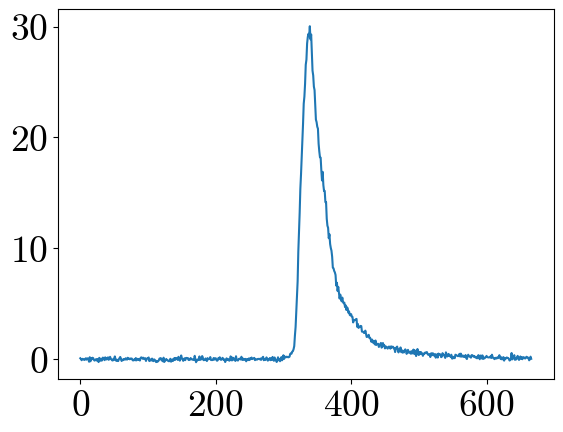

In [46]:
test_timeseries = np.nansum(intensity_ds, axis = 0)
plt.plot(test_timeseries)

In [47]:
off_pulse_indices_time_ds = np.arange(0, 25)
print(off_pulse_indices_time_ds)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24]


[<Axes: > <Axes: >]
[<Axes: > <Axes: >]


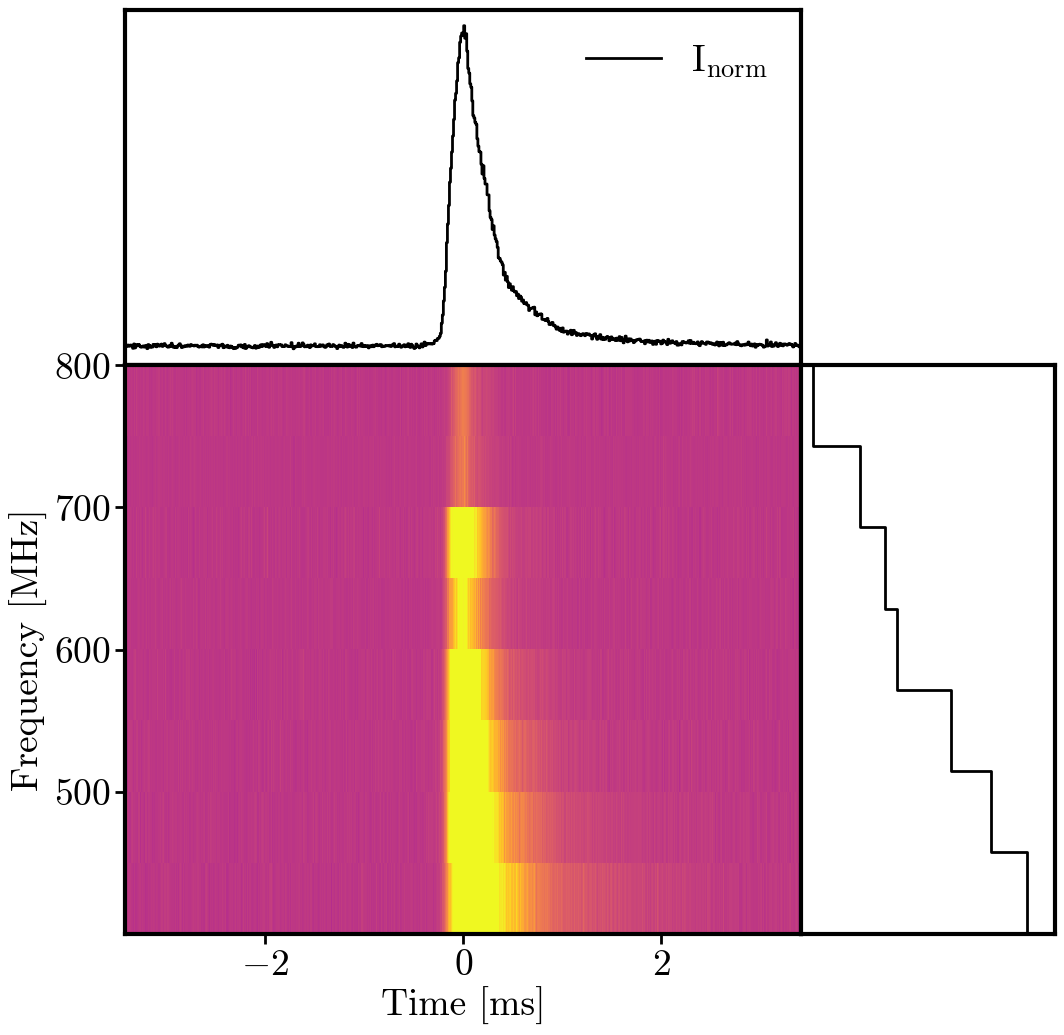

In [48]:
fres_ds = fres * f_factor
tres_ds = tres * t_factor

# Normalize intensity
offintensity_ds = intensity_ds[:, off_pulse_indices_time_ds]
intensity_ds = intensity_ds - np.nanmean(offintensity_ds)
intensity_ds = intensity_ds / np.nanstd(offintensity_ds)
intensity_ds_norm = intensity_ds / np.max(intensity_ds)

# Normalized spectrum
intensity_spectrum_ds = np.nansum(intensity_ds, axis=1)
offintensity_spectrum_ds = np.nansum(intensity_ds[:, off_pulse_indices_time_ds], axis=1)
intensity_spectrum_ds = intensity_spectrum_ds - np.nanmean(offintensity_spectrum_ds)
intensity_spectrum_ds = intensity_spectrum_ds / np.nanstd(offintensity_spectrum_ds)
spectrum_ds_norm = intensity_spectrum_ds / np.max(intensity_spectrum_ds)

# Channels
freqsamples_ds = np.linspace(f_min, f_max, spectrum_ds_norm.shape[0])

# Normalized timeseries
intensity_timeseries_ds = np.nansum(intensity_ds, axis=0)
offintensity_timeseries_ds = np.nansum(intensity_ds[:, off_pulse_indices_time_ds], axis=0)
intensity_timeseries_ds = intensity_timeseries_ds - np.nanmean(offintensity_timeseries_ds)
intensity_timeseries_ds = intensity_timeseries_ds / np.nanstd(offintensity_timeseries_ds)
timeseries_ds_norm = intensity_timeseries_ds / np.max(intensity_timeseries_ds)

# Samples
timesamples_ds = np.linspace(0, intensity_ds.shape[1]*tres_ds, intensity_ds.shape[1])
timerange_ds = np.abs(timesamples_ds[-1] - timesamples_ds[0])
timesamples_center_ds = np.linspace(-timerange_ds/2, timerange_ds/2, len(timesamples_ds))
timeshift_ds = -1 * int(timesamples_center_ds[np.argmax(savgol_filter(timeseries_ds_norm, 11, 3))] / tres_ds)

# Shift intensity to center
intensity_ds_norm = np.roll(intensity_ds_norm, timeshift_ds, axis = 1)
timeseries_ds_norm = np.roll(timeseries_ds_norm, timeshift_ds)


from matplotlib.colors import LogNorm

fig, axes = plt.subplots(
        nrows=2, ncols=2, sharex=False, sharey=False, 
        gridspec_kw={'height_ratios':[1.25,2], 'width_ratios':[2, 0.75]},
        figsize = (12, 12))

# Increase border thickness
current_axes = plt.gca()
for ax_row in axes:
    for ax in ax_row:
        ax.spines['top'].set_linewidth(3)
        ax.spines['bottom'].set_linewidth(3)
        ax.spines['left'].set_linewidth(3)
        ax.spines['right'].set_linewidth(3)
for ax_row in axes:
    print(ax_row)
    for ax in ax_row:
        ax.tick_params(which='both', width=2)
        ax.tick_params(which='major', length=7)
        ax.tick_params(which='minor', length=5)
        ax.tick_params(which='minor', axis = 'y', length=5)

axes[0, 0].step(timesamples_center_ds, timeseries_ds_norm, where = 'mid', c = 'k', alpha = 1, linewidth=2, label = 'I$_{\mathrm{norm}}$')
axes[0, 0].set_yticks([0, 1])
axes[0, 0].tick_params(axis='x',
        which='both', 
        bottom=False, 
        top=False, 
        labelbottom=False,
        width=2)
axes[0, 0].set_yticks([])
#axes[0, 0].set_ylim(-0.75, 1.35)
axes[0, 0].set_xlim(timesamples_center_ds[0], timesamples_center_ds[-1])
axes[0, 0].legend(loc = 'upper right', fontsize = 27, frameon = False)

mean_ds = np.nanmean(intensity_ds_norm)
std_ds = np.nanstd(intensity_ds_norm)
vmin_ds = mean_ds - 3*std_ds
vmax_ds = mean_ds + 3*std_ds
axes[1, 0].imshow(intensity_ds_norm, vmin = vmin_ds, vmax = vmax_ds, extent = [timesamples_center_ds[0], timesamples_center_ds[-1], freqsamples_ds[0], freqsamples_ds[-1]], cmap = 'plasma', aspect = 'auto', interpolation='nearest') 
axes[1, 0].set_ylabel('Frequency [MHz]')
axes[1, 0].set_xlabel('Time [ms]')

axes[0, 1].axis('off')
axes[0, 1].set_visible(False)

axes[1, 1].step(np.flip(spectrum_ds_norm), freqsamples_ds, where='mid', c = 'k', alpha = 1, linewidth=2)#, label = 'I$_{\mathrm{norm}}$')
axes[1, 1].tick_params(axis='y',
        which='both', 
        left=False, 
        right=False, 
        labelleft=False,
        width=2)
axes[1, 1].set_xticks([])
axes[1, 1].set_ylim(freqsamples_ds[0], freqsamples_ds[-1])

plt.subplots_adjust(hspace=0)
plt.subplots_adjust(wspace=0)

fig.savefig(f'{name}_chime_lowres_wfall_fscr{f_factor}_tscr{t_factor}.pdf', bbox_inches = 'tight')

plt.show()

In [49]:
importlib.reload(bft)

<module 'utilities.burstfittools' from '/arc/home/jfaber/baseband_morphologies/chime_dsa_codetections/scattering/utilities/burstfittools.py'>

In [50]:
n_channels = intensity_ds_norm.shape[0]
n_samples = intensity_ds_norm.shape[1]

# Create time array (ms)
time = np.linspace(0, n_samples*tres_ds, n_samples)

# Create frequency array with 128 channels
f_b = 0.40019  # GHz
f_t = 0.80019    # GHz
freq = np.linspace(f_b, f_t, n_channels)

# Set parameters for Model 3
#c0 = 1.0  # Reference flux at reference frequency
#spectral_index = 2.5
#t0 = 1.0  # ms
dm_init = 0.0
#DM_err = 0.0
#zeta = 0.08
#tau_1GHz = 0.6
#alpha = 4.0

# Parameters array for model 3
#params = [c0, spectral_index, t0, DM_err, zeta, tau_1GHz, alpha]

# Initialize the model and data
#data = np.zeros((N_channels, N_time_samples))
model_instance = bft.FRBModel(intensity_ds_norm, time, freq, dm_init)

# Add Gaussian noise to the simulated data
#np.random.seed(42)  # For reproducibility
#noise_level = 0.05 * np.max(simulated_data)  # Adjust noise level as needed
#noise = noise_level * np.random.randn(*simulated_data.shape)
#simulated_data_noisy = simulated_data + noise
#simulated_data_timeseries = simulated_data_noisy.sum(0) / np.max(simulated_data_noisy.sum(0))

Noise Sigma:  [0.00756638 0.00503152 0.00890671 0.00688269 0.00835056 0.00884313
 0.01110866 0.01678909]


In [51]:
print(np.max(np.nansum(intensity_ds_norm, axis=1)))

59.451603


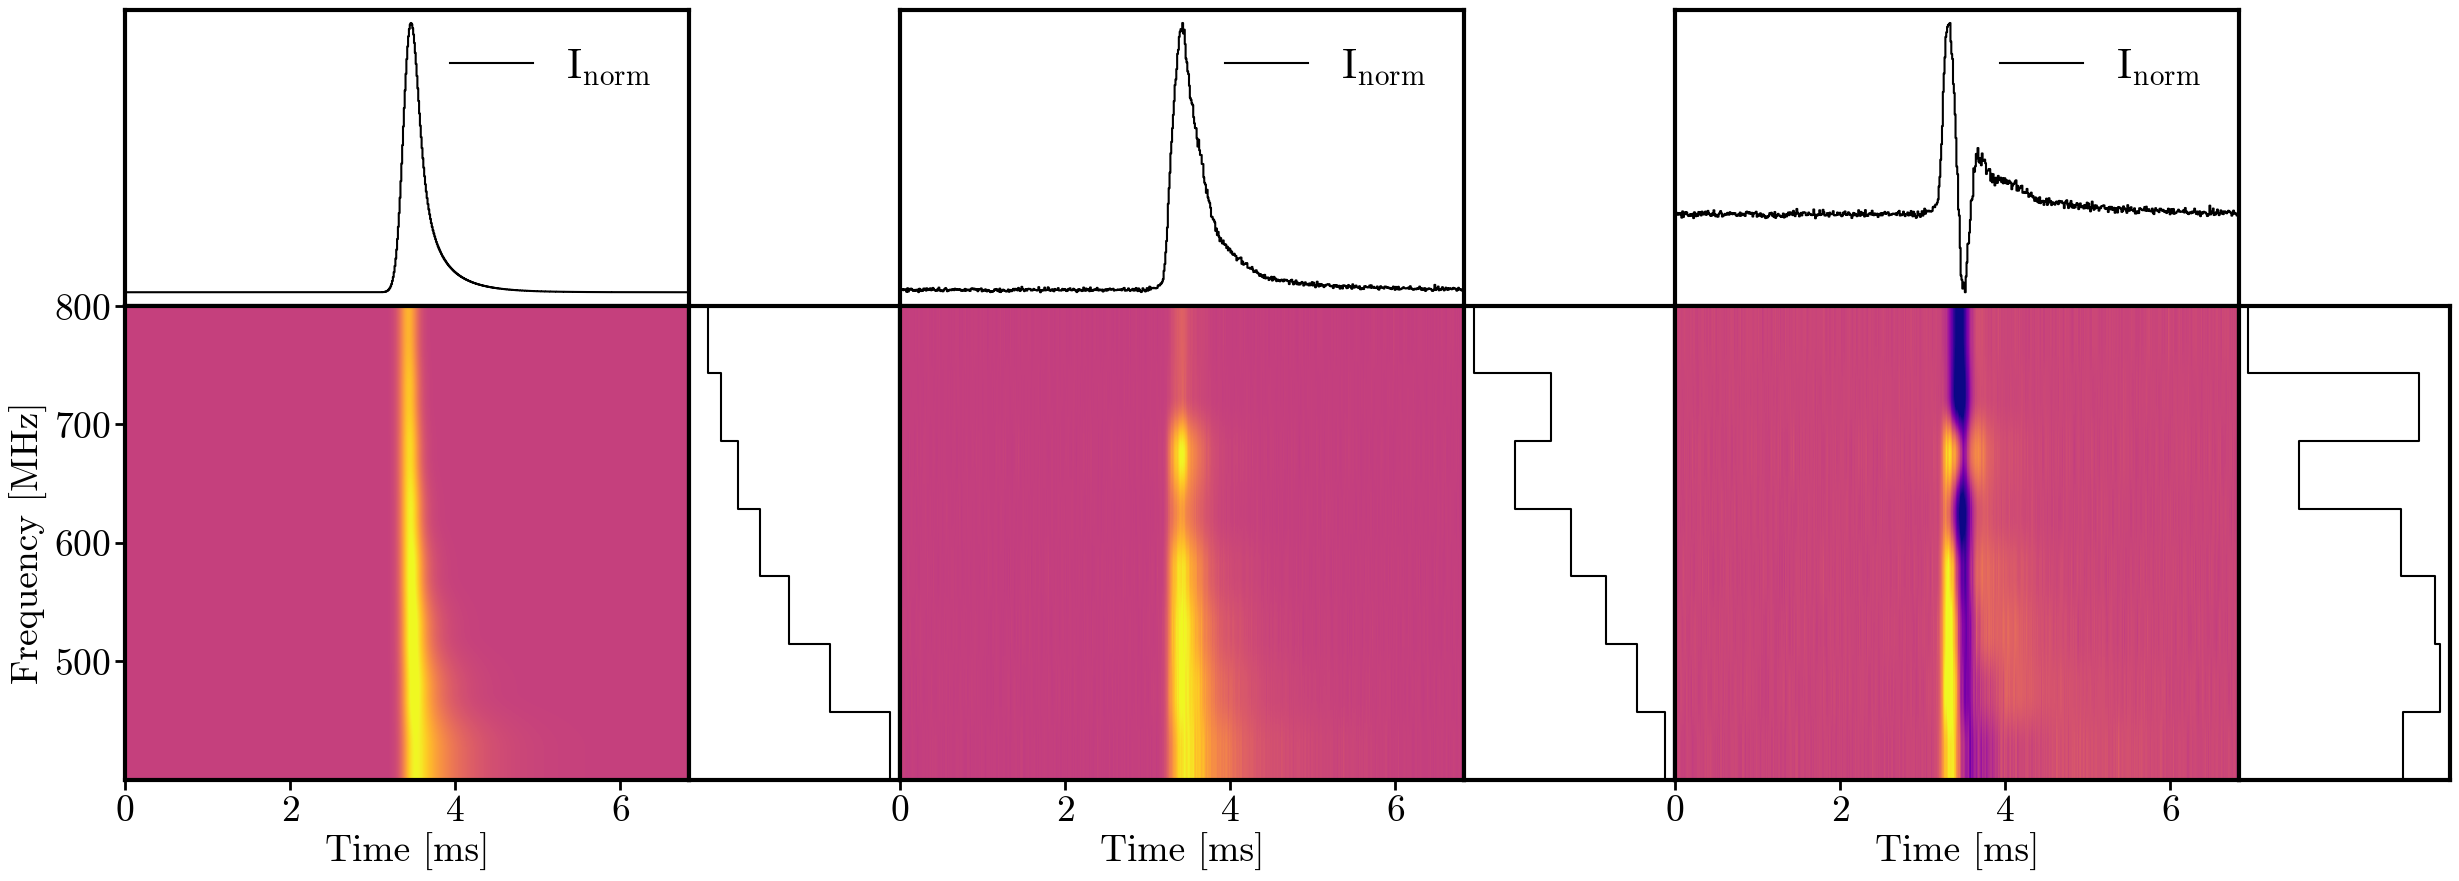

In [52]:
# --- (Assuming the simulated data and real data arrays have already been defined) ---
from scipy.signal import savgol_filter
# Generate simulated data (as in your original code)
c0_init = np.max(np.sum(intensity_ds_norm, axis=1))# / intensity_ds_norm.shape[1]
t0_init = timesamples_ds[np.argmax(np.sum(savgol_filter(intensity_ds_norm, 11, 3), axis=0))]
gamma_init = -2
#DM_err_init = 0.0
zeta_init = 0.08
tau_init = 0.01
#alpha_init = 4.0

model_type = 'model3'
if model_type == 'model0':
    #sim_params = [c0_init, t0_init, gamma_init, DM_err_init, 0., 0.]
    sim_params = [c0_init, t0_init, gamma_init, 0., 0.]
elif model_type == 'model1':
    #sim_params = [c0_init, t0_init, gamma_init, DM_err_init, zeta_init, 0.]
    sim_params = [c0_init, t0_init, gamma_init, zeta_init, 0.]
elif model_type == 'model2':
    #sim_params = [c0_init, t0_init, gamma_init, DM_err_init, tau_init, alpha_init, 0.]
    #sim_params = [c0_init, t0_init, gamma_init, DM_err_init, tau_init, 0.]
    sim_params = [c0_init, t0_init, gamma_init, tau_init, 0.]
elif model_type == 'model3':
    #sim_params = [c0_init, t0_init, gamma_init, DM_err_init, zeta_init, tau_init, alpha_init]
    #sim_params = [c0_init, t0_init, gamma_init, DM_err_init, zeta_init, tau_init]
    sim_params = [c0_init, t0_init, gamma_init, zeta_init, tau_init]

simulated_data = model_instance.model(sim_params, model_type=model_type)
simulated_data_norm = simulated_data / np.max(simulated_data)

sim_fres = fres_ds
sim_tres = tres_ds

sim_timeseries = np.nansum(simulated_data, axis=0)
sim_timeseries_norm = sim_timeseries / np.max(sim_timeseries)
sim_timesamples = np.linspace(0, simulated_data.shape[1]*sim_tres, simulated_data.shape[1])
sim_timerange = np.abs(sim_timesamples[-1] - sim_timesamples[0])
sim_timesamples_mod = np.linspace(-sim_timerange/2, sim_timerange/2, len(sim_timesamples))
sim_spectrum = np.nansum(simulated_data, axis=1)
sim_spectrum_norm = sim_spectrum / np.max(sim_spectrum)
sim_freqsamples = np.linspace(f_min, f_max, simulated_data.shape[0])

# Compute residuals and residual spectrum
intensity_rsdl = intensity_ds_norm - simulated_data_norm
timeseries_rsdl = timeseries_ds_norm - sim_timeseries_norm
rsdl_spectrum = np.nansum(intensity_rsdl, axis=1)
rsdl_spectrum_norm = rsdl_spectrum / np.max(rsdl_spectrum)

# Precompute means and stds for imshow scaling
sim_mean = np.nanmean(simulated_data_norm)
sim_std = np.nanstd(simulated_data_norm)
mean_ds = np.nanmean(intensity_ds_norm)
std_ds = np.nanstd(intensity_ds_norm)
mean_rsdl = np.nanmean(intensity_rsdl)
std_rsdl = np.nanstd(intensity_rsdl)

# Create a figure with 2 rows x 6 columns:
# Columns 0-1: Panel 1 (Simulated/Model)
# Columns 2-3: Panel 2 (Real Data)
# Columns 4-5: Panel 3 (Residual)
fig, axes = plt.subplots(
    nrows=2, ncols=6, sharex=False, sharey=False,
    gridspec_kw={'height_ratios': [1.25, 2],
                 'width_ratios': [2, 0.75, 2, 0.75, 2, 0.75]},
    figsize=(30, 10)
)

# Increase border thickness and set tick parameters for every axis
for ax_row in axes:
    for ax in ax_row:
        ax.spines['top'].set_linewidth(3)
        ax.spines['bottom'].set_linewidth(3)
        ax.spines['left'].set_linewidth(3)
        ax.spines['right'].set_linewidth(3)
        ax.tick_params(which='both', width=2)
        ax.tick_params(which='major', length=7)
        ax.tick_params(which='minor', length=5)
        ax.tick_params(which='minor', axis='y', length=5)

# ----- PANEL 1: Simulated Data (Model) -----
# Timeseries (top left of panel 1: column 0)
axes[0, 0].step(sim_timesamples, sim_timeseries_norm, where='mid', c='k', alpha=1, label='I$_{\mathrm{norm}}$')
axes[0, 0].set_yticks([])
axes[0, 0].tick_params(axis='x', bottom=False, top=False, labelbottom=False)
axes[0, 0].set_xlim(sim_timesamples[0], sim_timesamples[-1])
axes[0, 0].legend(loc='upper right', fontsize=30, frameon=False)

# Waterfall (bottom left of panel 1: column 0)
axes[1, 0].imshow(simulated_data_norm,
                   vmin=sim_mean - 6*sim_std, vmax=sim_mean + 6*sim_std,
                   extent=[sim_timesamples[0], sim_timesamples[-1], sim_freqsamples[0], sim_freqsamples[-1]],
                   cmap='plasma', aspect='auto')
axes[1, 0].set_ylabel('Frequency [MHz]')
axes[1, 0].set_xlabel('Time [ms]')

# Spectrum (bottom right of panel 1: column 1)
axes[1, 1].step(np.flip(sim_spectrum_norm), sim_freqsamples, where='pre', c='k', alpha=1, label='I$_{\mathrm{norm}}$')
#axes[1, 1].set_xlabel('Intensity')
axes[1, 1].set_xticks([])
axes[1, 1].set_ylim(sim_freqsamples[0], sim_freqsamples[-1])
axes[1, 1].tick_params(axis='y', left=False, right=False, labelleft=False)

# Hide the unused top axis for spectrum (column 1)
axes[0, 1].axis('off')
axes[0, 1].set_visible(False)

# ----- PANEL 2: Real Data -----
# Timeseries (top left of panel 2: column 2)
axes[0, 2].step(timesamples_ds, timeseries_ds_norm, where='mid', c='k', alpha=1, label='I$_{\mathrm{norm}}$')
axes[0, 2].set_yticks([])
axes[0, 2].tick_params(axis='x', bottom=False, top=False, labelbottom=False)
axes[0, 2].set_xlim(timesamples_ds[0], timesamples_ds[-1])
axes[0, 2].legend(loc='upper right', fontsize=30, frameon=False)

# Waterfall (bottom left of panel 2: column 2)
axes[1, 2].imshow(intensity_ds_norm,
                   vmin=mean_ds - 6*std_ds, vmax=mean_ds + 6*std_ds,
                   extent=[timesamples_ds[0], timesamples_ds[-1], freqsamples_ds[0], freqsamples_ds[-1]],
                   cmap='plasma', aspect='auto')
#axes[1, 2].set_ylabel('Frequency [MHz]')
axes[1, 2].set_yticks([])
axes[1, 2].set_xlabel('Time [ms]')

# Spectrum (bottom right of panel 2: column 3)
axes[1, 3].step(np.flip(spectrum_ds_norm), freqsamples_ds, where='pre', c='k', alpha=1, label='I$_{\mathrm{norm}}$')
#axes[1, 3].set_xlabel('Intensity')
axes[1, 3].set_xticks([])
axes[1, 3].set_ylim(freqsamples_ds[0], freqsamples_ds[-1])
axes[1, 3].tick_params(axis='y', left=False, right=False, labelleft=False)

# Hide the unused top axis for spectrum (column 3)
axes[0, 3].axis('off')
axes[0, 3].set_visible(False)

# ----- PANEL 3: Residuals -----
# Timeseries residual (top left of panel 3: column 4)
axes[0, 4].step(sim_timesamples, timeseries_rsdl, where='mid', c='k', alpha=1, label='I$_{\mathrm{norm}}$')
axes[0, 4].set_yticks([])
axes[0, 4].tick_params(axis='x', bottom=False, top=False, labelbottom=False)
axes[0, 4].set_xlim(sim_timesamples[0], sim_timesamples[-1])
axes[0, 4].legend(loc='upper right', fontsize=30, frameon=False)

# Waterfall residual (bottom left of panel 3: column 4)
axes[1, 4].imshow(intensity_rsdl,
                   vmin=mean_rsdl - 6*std_rsdl, vmax=mean_rsdl + 6*std_rsdl,
                   extent=[sim_timesamples[0], sim_timesamples[-1], sim_freqsamples[0], sim_freqsamples[-1]],
                   cmap='plasma', aspect='auto')
#axes[1, 4].set_ylabel('Frequency [MHz]')
axes[1, 4].set_yticks([])
axes[1, 4].set_xlabel('Time [ms]')

# Spectrum for residuals (bottom right of panel 3: column 5)
axes[1, 5].step(np.flip(rsdl_spectrum_norm), sim_freqsamples, where='pre', c='k', alpha=1, label='I$_{\mathrm{norm}}$')
#axes[1, 5].set_xlabel('Intensity')
axes[1, 5].set_xticks([])
axes[1, 5].set_ylim(sim_freqsamples[0], sim_freqsamples[-1])
axes[1, 5].tick_params(axis='y', left=False, right=False, labelleft=False)

# Hide the unused top axis for spectrum (column 5)
axes[0, 5].axis('off')
axes[0, 5].set_visible(False)
plt.subplots_adjust(hspace=0, wspace=0)

#fig.savefig(f'{name}_chime_initmodel_threepanel_ch16.pdf', bbox_inches = 'tight')

plt.show()


In [34]:
# Fit the models
prior_bounds = {
        'c0': (0, 0.05),  # Adjusted as per prior
        't0': (3.2, 3.35),
        'spectral_index': (-4, 0),
        #'DM_err': (-0.1, 0.1),
        'zeta': (0.1, 0.15),
        'tau_1GHz': (0.05, 0.15)
        #'alpha': (3.999999, 4.000001)
    }

nsteps = 600

results, best_model = bft.fit_models(model_instance, sim_params, prior_bounds, numsteps=nsteps, fit_m0=False, fit_m1=False, fit_m2=False, fit_m3=True)
print('\n')
print(f"The best-fitting model is: {best_model}")
print('\n')
print(results)

Check Prior Bounds:  {'c0': (0, 0.05), 't0': (3.2, 3.35), 'spectral_index': (-4, 0), 'zeta': (0.1, 0.15), 'tau_1GHz': (0.05, 0.15)}
Fitting Model 3


100%|██████████| 600/600 [00:39<00:00, 15.27it/s]

Difference in BIC is greater than 6, the best model is model3!
Difference in BIC is greater than 6, the best model is model3!
Difference in BIC is greater than 6, the best model is model3!
Difference in BIC is greater than 6, the best model is model3!
Best model is model3


The best-fitting model is: model3


{'model0': {'sampler': nan, 'BIC': nan, 'lnL_max': nan, 'k': nan}, 'model1': {'sampler': nan, 'BIC': nan, 'lnL_max': nan, 'k': nan}, 'model2': {'sampler': nan, 'BIC': nan, 'lnL_max': nan, 'k': nan}, 'model3': {'sampler': <emcee.ensemble.EnsembleSampler object at 0x7fbc44f3cac0>, 'BIC': 242822.08401397293, 'lnL_max': -121389.58642801747, 'k': 5}}


In [35]:
# Extract the sampler
best_sampler = results[best_model]['sampler']

print("Mean acceptance fraction (should be 0.2-0.5):", np.mean(best_sampler.acceptance_fraction))

# Check for NaN or Inf in Sampler
log_probs = best_sampler.get_log_prob()
if np.any(~np.isfinite(log_probs)):
    print("Found NaN or Inf in log-probabilities.")

#samples = best_sampler.get_chain(flat=True)
# Discard burn-in samples
burn_in = nsteps // 4
# Extract the samples
samples = best_sampler.get_chain(discard=burn_in, flat=True)
# Extract the log probability
log_prob = best_sampler.get_log_prob(discard=burn_in, flat=True)

# Determine the indices of the relevant parameters
if best_model == 'model0':
    param_indices = [0, 1, 2]
elif best_model == 'model1':
    param_indices = [0, 1, 2, 3]
elif best_model == 'model2':
    param_indices = [0, 1, 2, 3]
elif best_model == 'model3':
    param_indices = [0, 1, 2, 3, 4]

# Extract the relevant samples
relevant_samples = samples[:, param_indices]
samples = relevant_samples

# Define labels for the parameters
#labels = ['c0', 't0', 'spectral_index', 'DM_err']
labels = ['c0', 't0', 'spectral_index']
if best_model in ['model1', 'model3']:
    labels.append('zeta')
if best_model in ['model2', 'model3']:
    #labels.extend(['tau_1GHz', 'alpha'])
    labels.extend(['tau_1GHz'])

Mean acceptance fraction (should be 0.2-0.5): 0.41973333333333335


In [36]:
# Calculate parameter estimates and their uncertainties
best_fit_params = []
best_fit_params_dict = {}
lower_err = []
upper_err = []
for i, label in enumerate(labels):
    mcmc = np.percentile(samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    print(f"{label} = {mcmc[1]:.3f} (+{q[1]:.3f}, -{q[0]:.3f})")
    best_fit_params.append(mcmc[1])
    lower_err.append(-q[0])
    upper_err.append(+q[1])
    best_fit_params_dict[f'{label}'] = (mcmc[1], +q[1], -q[0])

best_fit_params_dict['alpha'] = 4.0
    
# Generate simulated data
initial_params = {}
initial_params['c0_init'] = c0_init
initial_params['t0_init'] = t0_init
initial_params['gamma_init'] = gamma_init
#initial_params['DM_err_init'] = DM_err_init
initial_params['zeta_init'] = zeta_init
initial_params['tau_init'] = tau_init
#initial_params['alpha_init'] = alpha_init

best_fit_params_dict['initial_params'] = initial_params
best_fit_params_dict['prior_bounds'] = prior_bounds


c0 = 0.002 (+0.000, -0.000)
t0 = 3.275 (+0.001, -0.000)
spectral_index = -3.784 (+0.006, -0.009)
zeta = 0.100 (+0.000, -0.000)
tau_1GHz = 0.050 (+0.000, -0.000)


Best Fit Params: [0.0023312192394478507, 3.2747454207206785, -3.78413749343563, 0.10000414846115857, 0.050000794110786055]


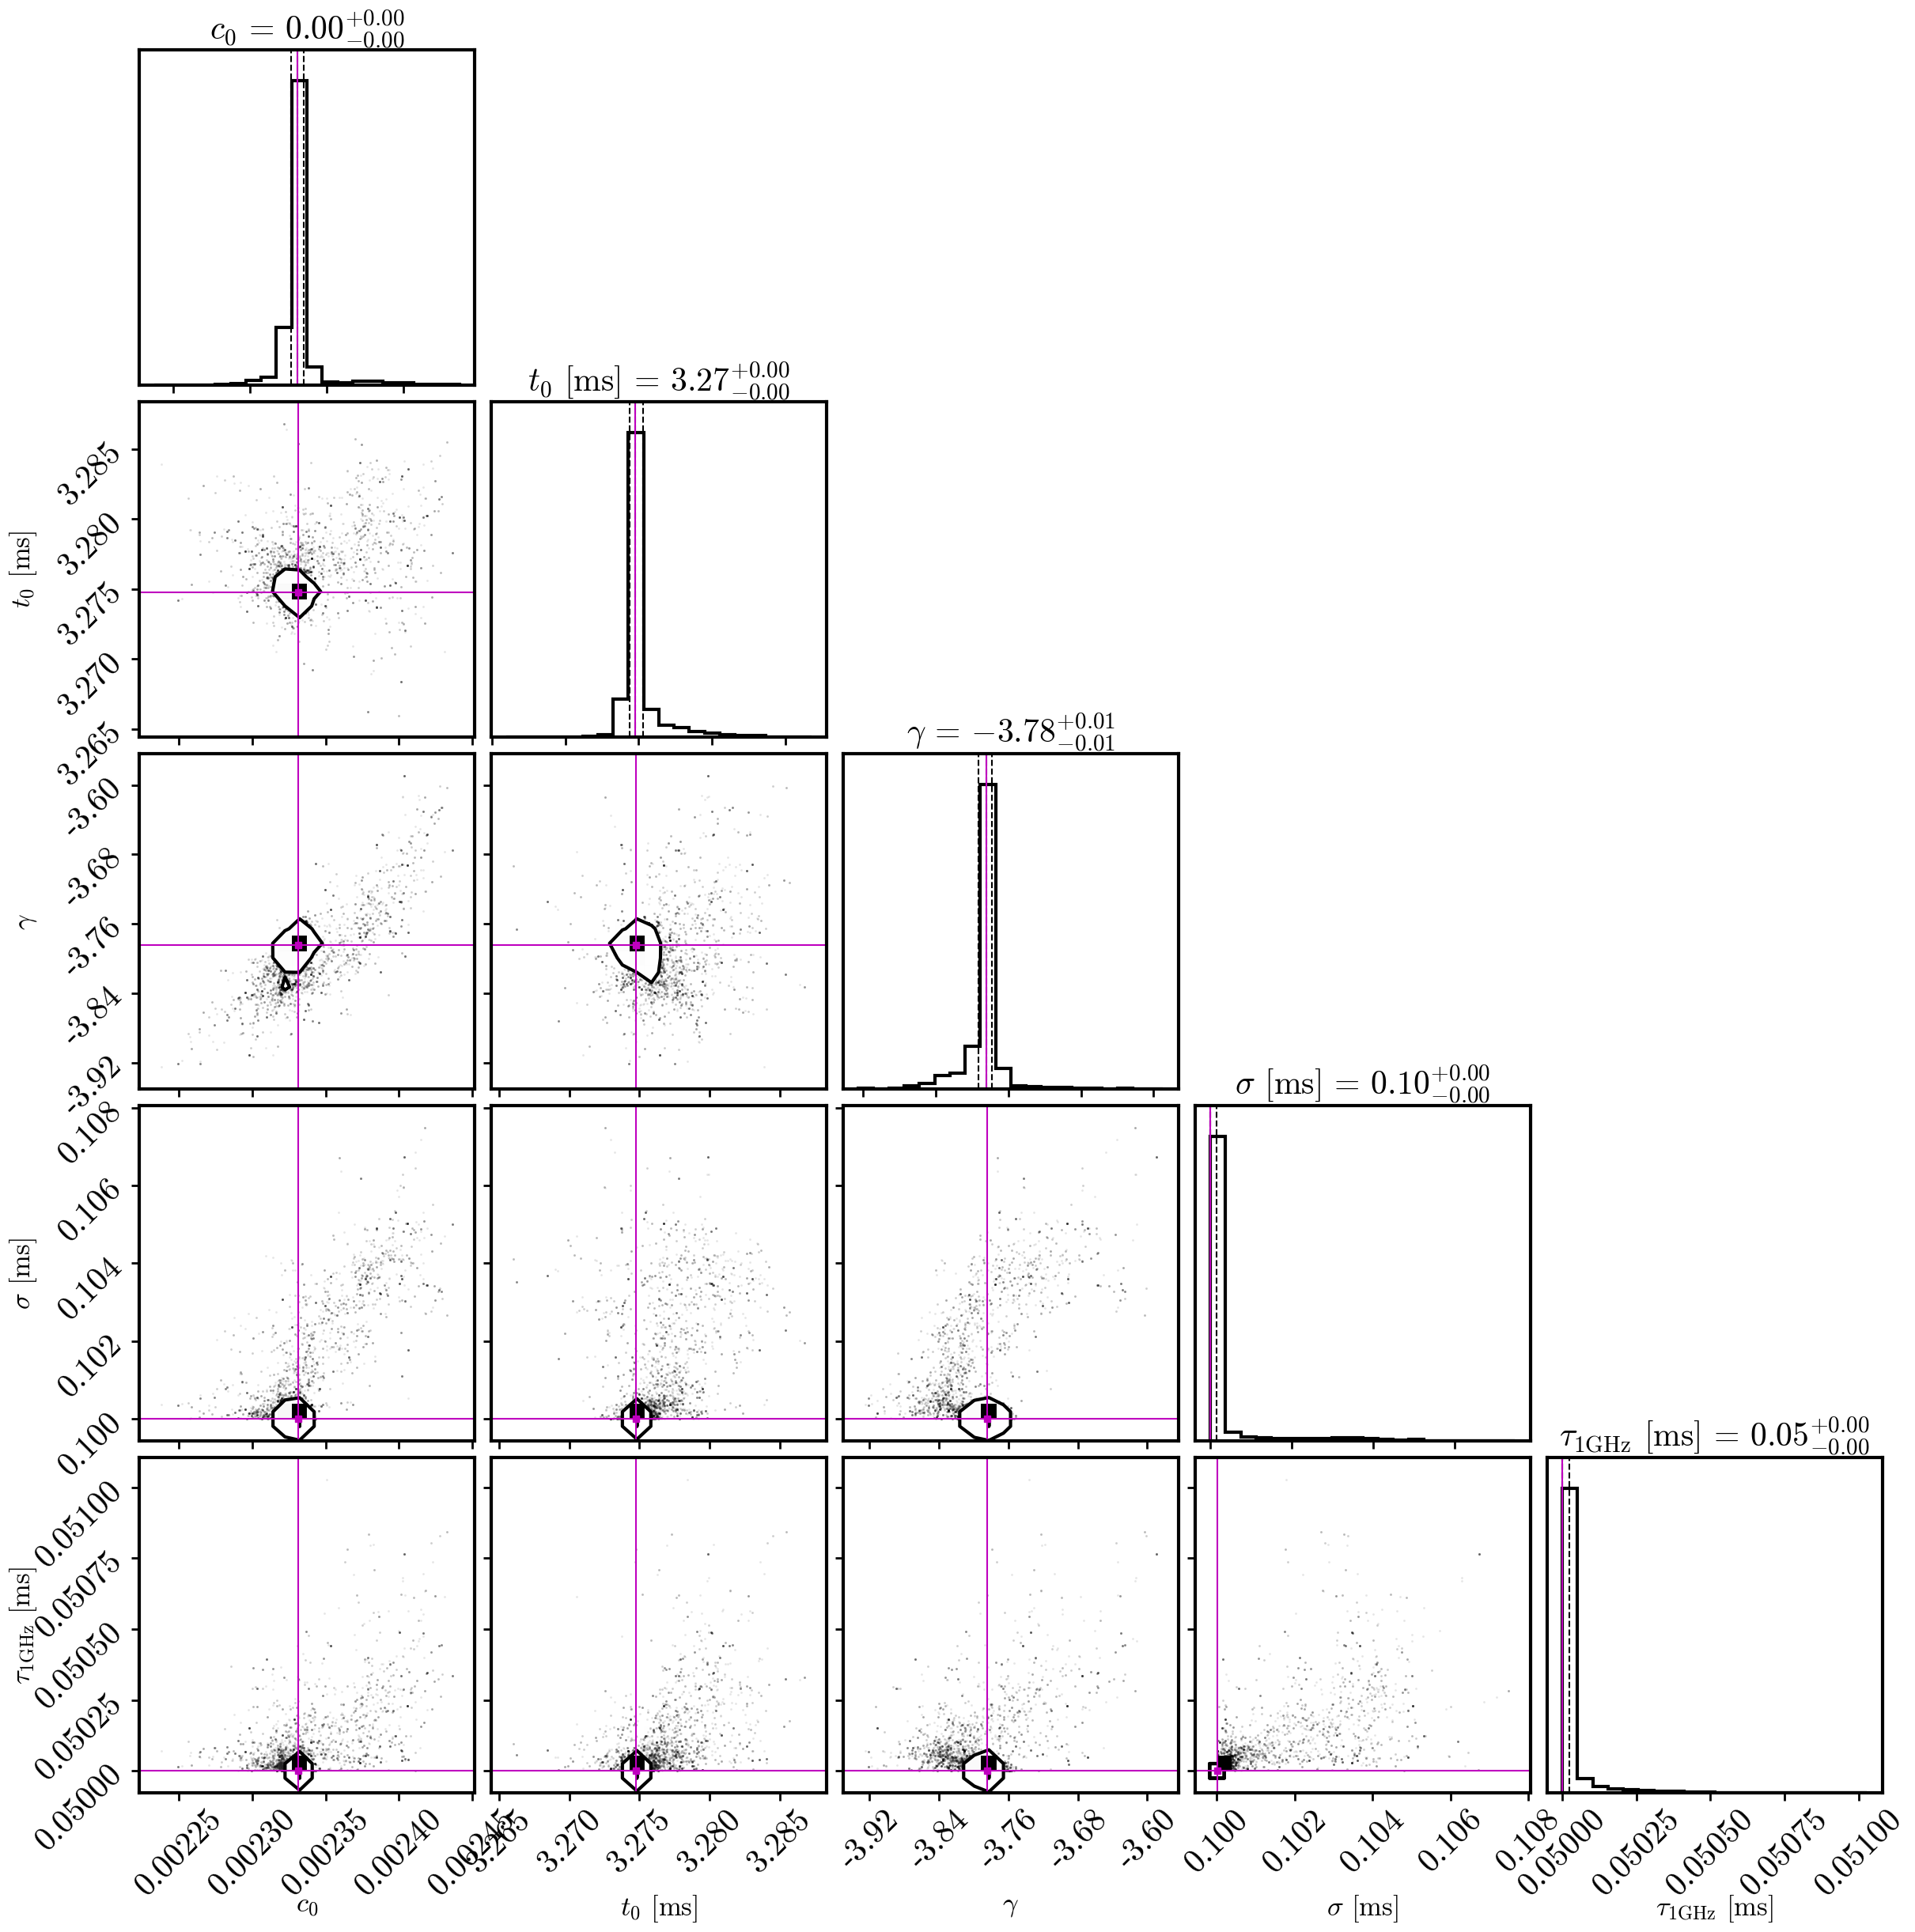

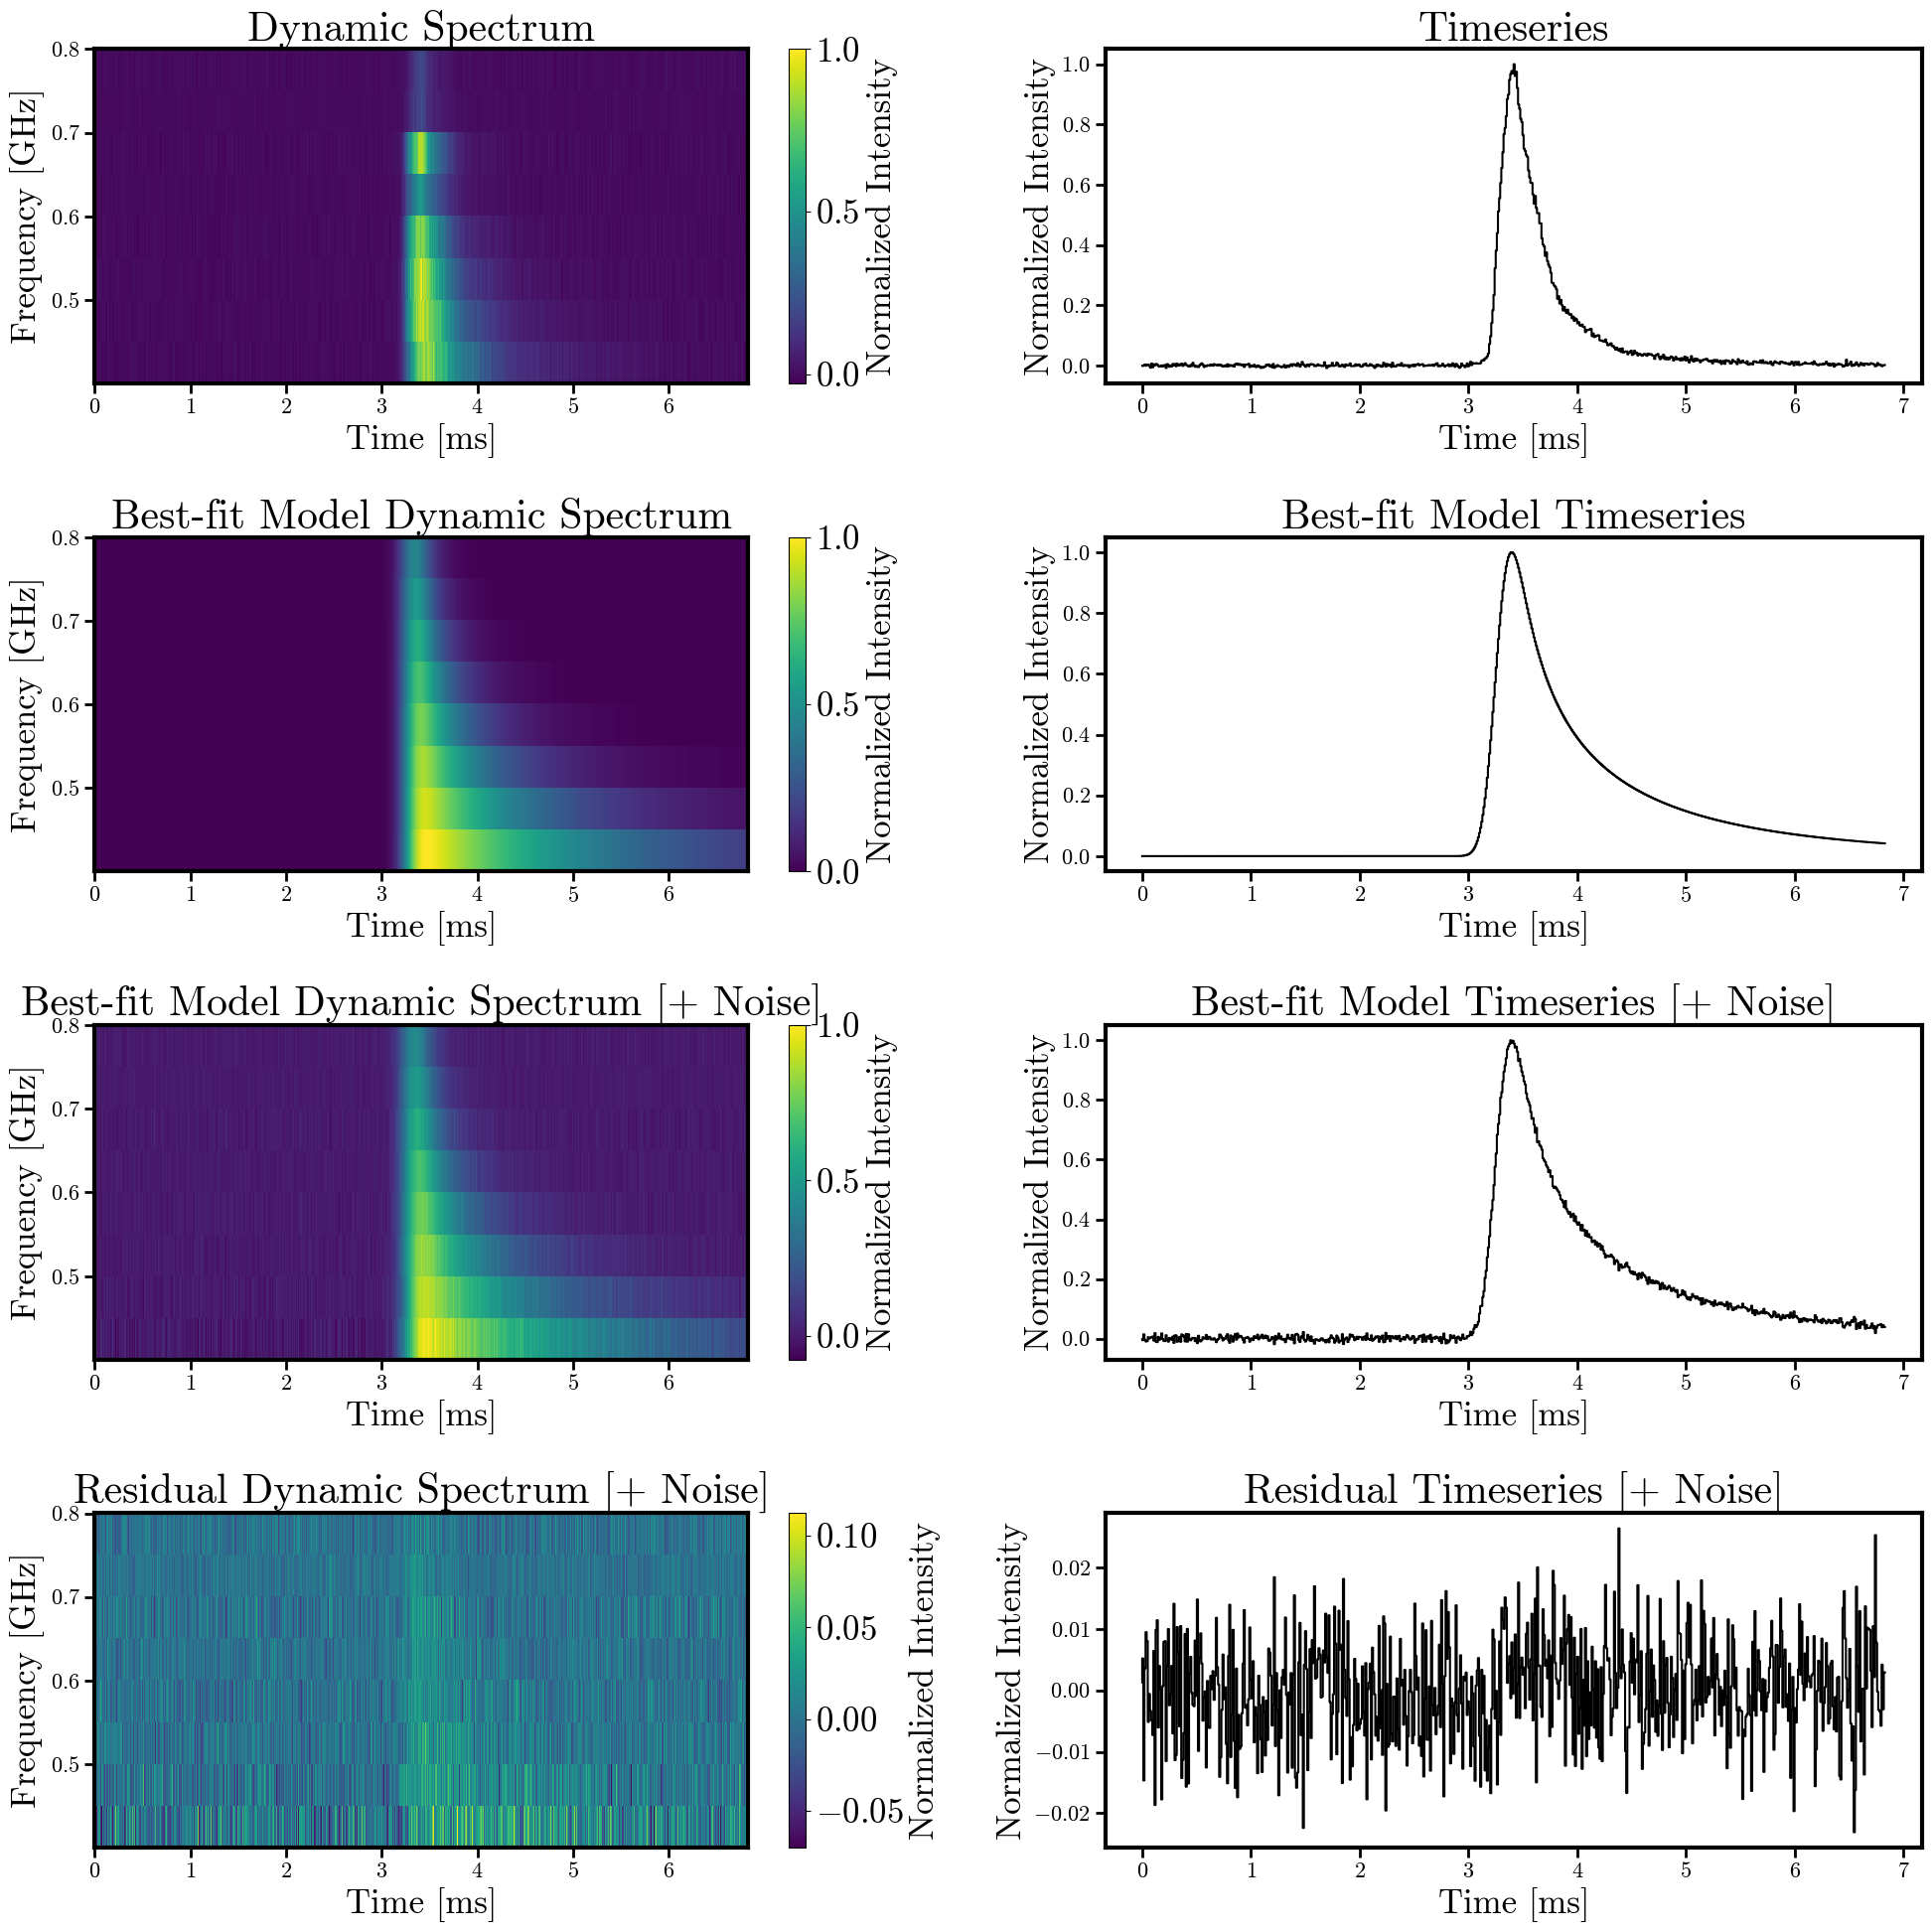

Mean acceptance fraction: 0.41973333333333335


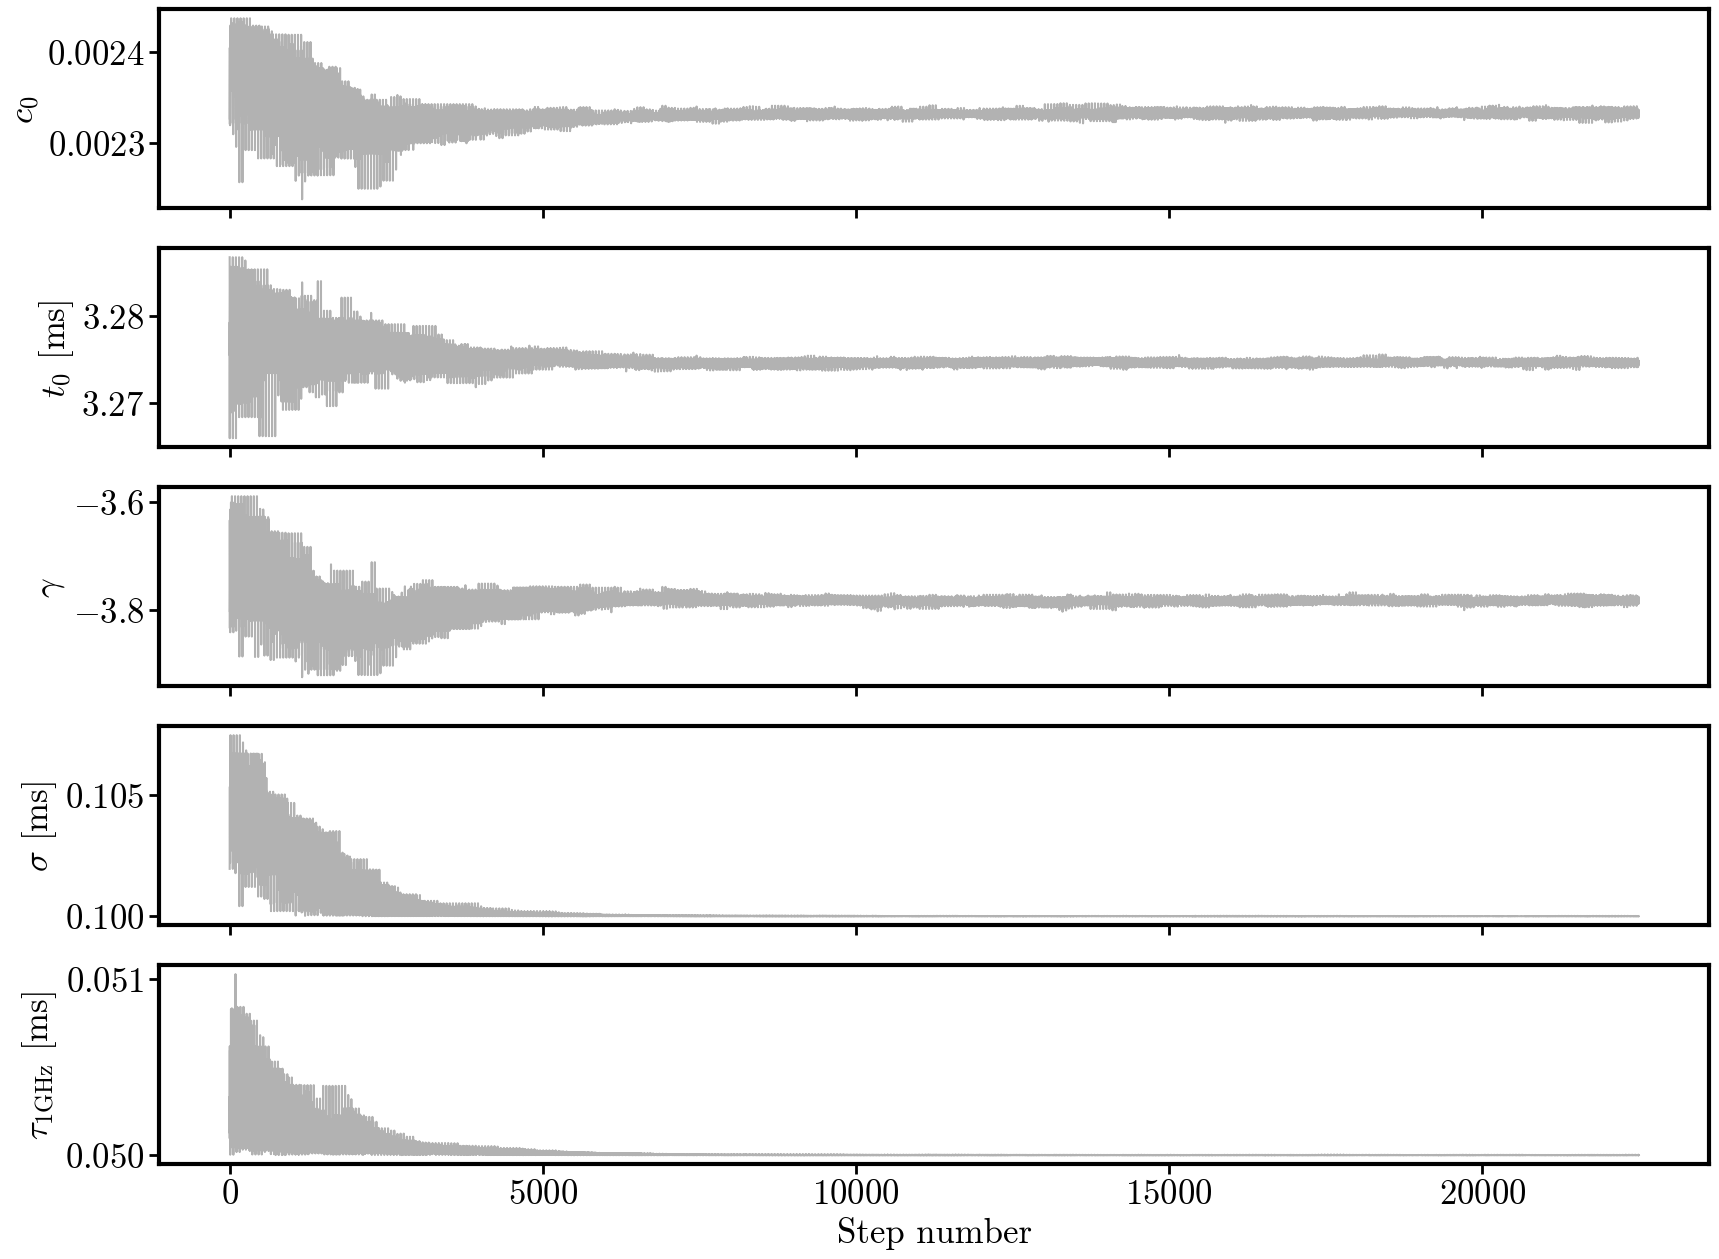

In [37]:
# Plot the data and the best-fit model
#best_fit_index = np.argmax(best_sampler.get_log_prob(discard=burn_in, flat=True))
#best_fit_index = np.argmax(log_prob)
#best_fit_params = samples[best_fit_index]

print(f'Best Fit Params: {best_fit_params}')

rcParams['font.size'] = 25

# Plot the corner plot
# Define figure size before creating the corner plot
fig = plt.figure(figsize=(25, 25))  # Adjust width and height

labels = [r'$c_0$', r'$t_0$ [ms]', r'$\gamma$', r'$\sigma$ [ms]', r'$\tau_\mathrm{1GHz}$ [ms]']

#ranges = [(0, 1), (126, 127.5), (-2.2, 2.2), (0, 1.75), (50, 110)]

fig = corner.corner(relevant_samples, labels=labels, truths=best_fit_params, quantiles=[0.16, 0.5, 0.84], show_titles=True, title_kwargs={'fontsize': 30}, fig=fig, truth_color='m', hist_kwargs={'linewidth': 3, 'histtype': 'step'}, contour_kwargs={'linewidths': 3})

for ax in fig.axes:
    # Spine widths
    ax.spines['top'].set_linewidth(3)
    ax.spines['bottom'].set_linewidth(3)
    ax.spines['left'].set_linewidth(3)
    ax.spines['right'].set_linewidth(3)

    # Tick parameters
    ax.tick_params(which='both', width=2)
    ax.tick_params(which='major', length=7)
    ax.tick_params(which='minor', length=5)
    ax.tick_params(which='minor', axis='y', length=5)
    ax.tick_params(axis='both', labelsize=30)

fig.savefig(f'{name}_chime_corner_fscr{f_factor}_tscr{t_factor}.pdf', bbox_inches = 'tight')
plt.show()

# Compute the model spectrum using the best-fit parameters
best_fit_model = model_instance.model(best_fit_params, model_type=best_model)

# Normalized data
model_data = best_fit_model
model_offdata = model_data[:, off_pulse_indices_time_ds]
model_offdata_spectrum = np.nansum(model_offdata, axis=1)
model_offdata_timeseries = np.nansum(model_offdata, axis=0)

norm_model = model_data - np.nanmean(model_offdata)
norm_model = norm_model / np.nanstd(model_offdata)
norm_model = norm_model / np.max(norm_model)

model_data_timeseries = np.nansum(model_data, axis=0)
norm_model_timeseries = model_data_timeseries - np.nanmean(model_offdata_timeseries)
norm_model_timeseries = norm_model_timeseries / np.nanstd(model_offdata_timeseries)
norm_model_timeseries = norm_model_timeseries / np.max(norm_model_timeseries)

model_data_spectrum = np.sum(model_data, axis=1)
norm_model_spectrum = model_data_spectrum - np.nanmean(model_offdata_spectrum)
norm_model_spectrum = norm_model_spectrum / np.nanstd(model_offdata_spectrum)
norm_model_spectrum = norm_model_spectrum / np.max(norm_model_spectrum)

# Plot the data and the best-fit model separately for comparison
fig = plt.figure(figsize=(20, 20))

for i in range(1, 9):
    plt.subplot(4, 2, i)
    ax = plt.gca()
    
    # Spine widths
    ax.spines['top'].set_linewidth(3)
    ax.spines['bottom'].set_linewidth(3)
    ax.spines['left'].set_linewidth(3)
    ax.spines['right'].set_linewidth(3)

    # Tick parameters
    ax.tick_params(which='both', width=2)
    ax.tick_params(which='major', length=7)
    ax.tick_params(which='minor', length=5)
    ax.tick_params(which='minor', axis='y', length=5)
    ax.tick_params(axis='both', labelsize=16)

# Plot the data
plt.subplot(4, 2, 1)
extent = [time[0], time[-1], freq[0], freq[-1]]
plt.imshow(intensity_ds_norm, extent=extent, aspect='auto', origin='upper', cmap='viridis', interpolation='nearest')
plt.colorbar(label='Normalized Intensity')
plt.xlabel('Time [ms]')
plt.ylabel('Frequency [GHz]')
plt.title('Dynamic Spectrum')

plt.subplot(4, 2, 2)
plt.step(time, timeseries_ds_norm, c='k')
plt.xlabel('Time [ms]')
plt.ylabel('Normalized Intensity')
plt.title('Timeseries')

# Plot the best-fit model
plt.subplot(4, 2, 3)
plt.imshow(norm_model, extent=extent, aspect='auto', origin='upper', cmap='viridis', interpolation='nearest')
#plt.imshow(norm_noisy_model, extent=extent, aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(label='Normalized Intensity')
plt.xlabel('Time [ms]')
plt.ylabel('Frequency [GHz]')
plt.title('Best-fit Model Dynamic Spectrum')

plt.subplot(4, 2, 4)
plt.step(time, norm_model_timeseries, c='k')
#plt.plot(time, norm_noisy_timeseries)
plt.xlabel('Time [ms]')
plt.ylabel('Normalized Intensity')
plt.title('Best-fit Model Timeseries')

# Plot the best-fit model with added noise (based on the original data)
# Generate synthetic noise with the same shape as the model
#noise = np.random.normal(loc=0.0, scale=model_instance.noise_std[:, np.newaxis], size=best_fit_model.shape)
noise_sigma = model_instance.noise_std
noise = np.random.lognormal(mean=0.0, sigma=noise_sigma[:, np.newaxis], size=best_fit_model.shape)

# Add the synthetic noise to the fitted model
noisy_model = best_fit_model + noise #savgol_filter(noise, 7, 3)
noisy_offmodel = noisy_model[:, off_pulse_indices_time_ds]
norm_noisy_model = noisy_model - np.mean(noisy_offmodel)
norm_noisy_model = norm_noisy_model / np.nanstd(noisy_offmodel)
norm_noisy_model = norm_noisy_model / np.max(norm_noisy_model)

# Integrate to get the noisy timeseries
noisy_timeseries = np.nansum(norm_noisy_model, axis = 0)
noisy_offtimeseries = np.nansum(norm_noisy_model[:, off_pulse_indices_time_ds], axis = 0)
norm_noisy_timeseries = noisy_timeseries - np.mean(noisy_offtimeseries)
norm_noisy_timeseries = norm_noisy_timeseries / np.nanstd(noisy_offtimeseries)
norm_noisy_timeseries = norm_noisy_timeseries / np.max(norm_noisy_timeseries)

# Integrate to get the noisy spectrum
noisy_spectrum = np.nansum(norm_noisy_model, axis = 1)
noisy_offspectrum = np.nansum(norm_noisy_model[:, off_pulse_indices_time_ds], axis = 1)
norm_noisy_spectrum = noisy_spectrum - np.mean(noisy_offspectrum)
norm_noisy_spectrum = norm_noisy_spectrum / np.nanstd(noisy_offspectrum)
norm_noisy_spectrum = norm_noisy_spectrum / np.max(norm_noisy_spectrum)

plt.subplot(4, 2, 5)
#plt.imshow(norm_model, extent=extent, aspect='auto', origin='lower', cmap='viridis')
plt.imshow(norm_noisy_model, extent=extent, aspect='auto', origin='upper', cmap='viridis', interpolation='nearest')
plt.colorbar(label='Normalized Intensity')
plt.xlabel('Time [ms]')
plt.ylabel('Frequency [GHz]')
plt.title('Best-fit Model Dynamic Spectrum [+ Noise]')

plt.subplot(4, 2, 6)
#plt.plot(time, norm_model_timeseries)
plt.step(time, norm_noisy_timeseries, c='k')
plt.xlabel('Time [ms]')
plt.ylabel('Normalized Intensity')
plt.title('Best-fit Model Timeseries [+ Noise]')

# Plot the residuals
plt.subplot(4, 2, 7)
plt.imshow(norm_model - norm_noisy_model, extent=extent, aspect='auto', origin='upper', cmap='viridis', interpolation='nearest')
plt.colorbar(label='Normalized Intensity')
plt.xlabel('Time [ms]')
plt.ylabel('Frequency [GHz]')
plt.title('Residual Dynamic Spectrum [+ Noise]')

plt.subplot(4, 2, 8)
plt.step(time, norm_model_timeseries - norm_noisy_timeseries, c='k')
plt.xlabel('Time [ms]')
plt.ylabel('Normalized Intensity')
plt.title('Residual Timeseries [+ Noise]')

plt.tight_layout()

#fig.savefig(f'{name}_chime_finalmodel_eightpanel.pdf', bbox_inches = 'tight')

plt.show()

# Check the mean acceptance fraction
print("Mean acceptance fraction:", np.mean(best_sampler.acceptance_fraction))

# Trace plots to assess convergence
ndim = len(labels)
fig, axes = plt.subplots(ndim, figsize=(20, 15), sharex=True)
for i in range(ndim):
    axes[i].plot(samples[:, i], "k", alpha=0.3)
    axes[i].set_ylabel(labels[i])
    # Spine widths
    axes[i].spines['top'].set_linewidth(3)
    axes[i].spines['bottom'].set_linewidth(3)
    axes[i].spines['left'].set_linewidth(3)
    axes[i].spines['right'].set_linewidth(3)

    # Tick parameters
    axes[i].tick_params(which='both', width=2)
    axes[i].tick_params(which='major', length=7)
    axes[i].tick_params(which='minor', length=5)
    axes[i].tick_params(which='minor', axis='y', length=5)
axes[-1].set_xlabel("Step number")

#fig.savefig(f'{name}_chime_traces_ch16.pdf', bbox_inches = 'tight')

plt.show()


In [32]:
print(best_fit_params_dict)

{'c0': (0.0011392768511118846, 2.942495930187026e-06, -9.135705624931708e-06), 't0': (3.3410728556939624, 0.0007821280030486655, -0.0005443614583486855), 'spectral_index': (-3.9995570973500207, 0.008724518695716998, -0.0003754236079425155), 'zeta': (0.014996794419327542, 2.7867154740006395e-06, -3.748775071996113e-05), 'tau_1GHz': (0.014998830294516121, 1.0326507690564674e-06, -2.5978646484221476e-05), 'alpha': 4.0, 'initial_params': {'c0_init': 59.451603, 't0_init': 3.41504, 'gamma_init': -2, 'zeta_init': 0.08, 'tau_init': 0.01}, 'prior_bounds': {'c0': (0, 0.05), 't0': (3.2, 3.35), 'spectral_index': (-4, 0), 'zeta': (0.01, 0.015), 'tau_1GHz': (0.005, 0.015)}}


In [95]:
time_plot = np.linspace(0, intensity_ds_norm.shape[1]*tres_ds, intensity_ds_norm.shape[1])
print(time_plot.shape)
time_plot_center = np.linspace(-1*time_plot[-1]//2, time_plot[-1]//2, intensity_ds_norm.shape[1])
freq_plot = np.linspace(f_b, f_t, intensity_ds_norm.shape[0])
print(freq_plot.shape)
model_instance_plot = bft.FRBModel(intensity_ds_norm, time_plot, freq_plot, dm_init)
best_fit_model_plot = model_instance_plot.model(best_fit_params, model_type=best_model)
best_fit_offmodel_plot = best_fit_model_plot[:, off_pulse_indices_time_ds]
best_fit_offmodel_timeseries = np.nansum(best_fit_offmodel_plot, axis=0)
best_fit_offmodel_spectrum = np.nansum(best_fit_offmodel_plot, axis=1)
print(best_fit_model_plot.shape)

(667,)
(8,)
Noise Sigma:  [0.00741473 0.00493455 0.00869721 0.00685381 0.00819436 0.00880217
 0.01093966 0.01648849]
(8, 667)


In [96]:
# Normalized model
model_plot = best_fit_model_plot - np.nanmean(best_fit_offmodel_plot)
norm_model_plot = model_plot / np.nanstd(best_fit_offmodel_plot)
norm_model_plot = norm_model_plot / np.max(norm_model_plot)

model_timeseries_plot = np.nansum(norm_model_plot, axis = 0)
norm_model_timeseries_plot = model_timeseries_plot - np.mean(best_fit_offmodel_timeseries)
norm_model_timeseries_plot = norm_model_timeseries_plot / np.nanstd(best_fit_offmodel_timeseries)
norm_model_timeseries_plot = norm_model_timeseries_plot / np.max(norm_model_timeseries_plot)

model_spectrum_plot = np.nansum(norm_model_plot, axis = 1)
norm_model_spectrum_plot = model_spectrum_plot - np.mean(best_fit_offmodel_spectrum)
norm_model_spectrum_plot = norm_model_spectrum_plot / np.nanstd(best_fit_offmodel_spectrum)
norm_model_spectrum_plot = norm_model_spectrum_plot / np.max(norm_model_spectrum_plot)


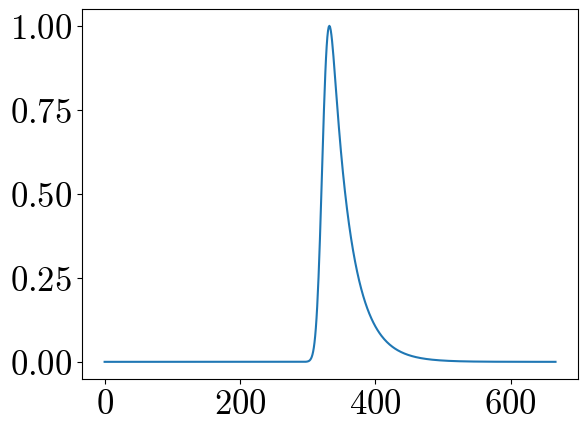

In [97]:
plt.plot(norm_model_timeseries_plot)

In [98]:
-((time_plot[-1] - time_plot[0])//2)

-3.0

NameError: name 'time_plot' is not defined

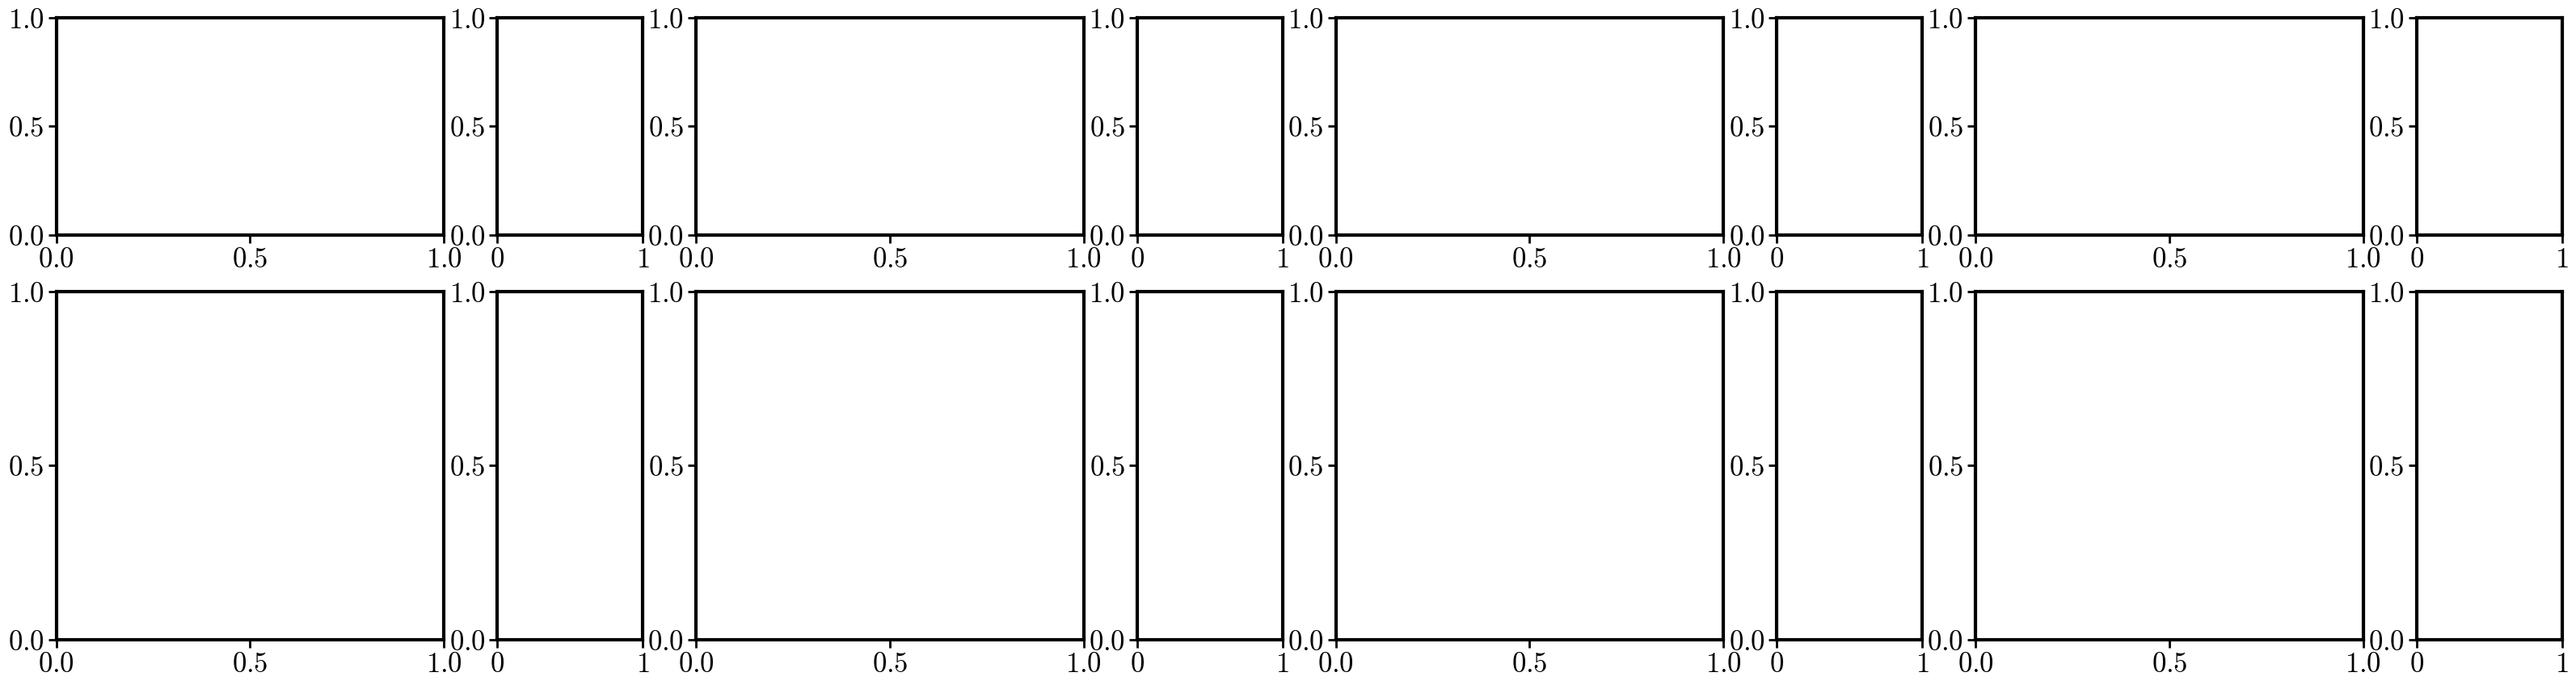

In [38]:
fig, axes = plt.subplots(
    nrows=2, ncols=8, sharex=False, sharey=False,
    gridspec_kw={'height_ratios': [1.25, 2],
                 'width_ratios': [2, 0.75, 2, 0.75, 2, 0.75, 2, 0.75]},
    figsize=(40, 10)
)

rcParams['font.size'] = 40

# Increase border thickness and set tick parameters for every axis
for ax_row in axes:
    for ax in ax_row:
        ax.spines['top'].set_linewidth(3)
        ax.spines['bottom'].set_linewidth(3)
        ax.spines['left'].set_linewidth(3)
        ax.spines['right'].set_linewidth(3)
        ax.tick_params(which='both', width=2)
        ax.tick_params(which='major', length=7)
        ax.tick_params(which='minor', length=5)
        ax.tick_params(which='minor', axis='y', length=5)


extent = [-((time_plot[-1] - time_plot[0])//2), (time_plot[-1] - time_plot[0])//2, freq_plot[0], freq_plot[-1]]

# ----- PANEL 1: Real Data -----
# Timeseries (top left of panel 1: column 0)
axes[0, 0].step(time_plot, timeseries_ds_norm, where='mid', c='k', alpha=1, linewidth=2, label='I$_{\mathrm{data}}$')
axes[0, 0].set_yticks([])
axes[0, 0].set_ylim(-0.75, 2)
axes[0, 0].tick_params(axis='x', bottom=False, top=False, labelbottom=False)
axes[0, 0].set_xlim(sim_timesamples[0], sim_timesamples[-1])
axes[0, 0].legend(loc='upper right', fontsize=30, frameon=False)
#axes[0, 0].text(1.4, 1.4, r'$\mathbf{A}$', color='k', fontsize=35)

# Waterfall (bottom left of panel 1: column 0)
axes[1, 0].imshow(intensity_ds_norm, extent=extent, vmin = -0.5, vmax = 1, cmap='plasma', aspect='auto', interpolation='nearest')
axes[1, 0].set_ylabel('Frequency [GHz]')
axes[1, 0].set_xlabel('Time [ms]')

# Spectrum (bottom right of panel 1: column 1)
axes[1, 1].step(np.flip(spectrum_ds_norm), freq_plot, where='mid', c='k', alpha=1, linewidth=2)
#axes[1, 1].set_xlabel('Intensity')
axes[1, 1].set_xticks([])
axes[1, 1].set_xlim(-2, 4)
axes[1, 1].set_ylim(freq[0], freq[-1])
axes[1, 1].tick_params(axis='y', left=False, right=False, labelleft=False)

# Hide the unused top axis for spectrum (column 1)
axes[0, 1].axis('off')
axes[0, 1].set_visible(False)

# ----- PANEL 2: Simulated Data (Model) -----
# Timeseries (top left of panel 1: column 0)
axes[0, 2].step(time_plot, norm_model_timeseries_plot, where='mid', c='k', alpha=1, linewidth=2, label='I$_{\mathrm{model}}$')
axes[0, 2].set_yticks([])
axes[0, 2].set_ylim(-0.75, 2)
axes[0, 2].tick_params(axis='x', bottom=False, top=False, labelbottom=False)
axes[0, 2].set_xlim(time[0], time[-1])
axes[0, 2].legend(loc='upper right', fontsize=35, frameon=False)
#axes[0, 2].text(1.4, 1.4, r'$\mathbf{B}$', color='k', fontsize=35)

# Waterfall (bottom left of panel 1: column 0)
axes[1, 2].imshow(norm_model, extent=extent, cmap='plasma', aspect='auto', interpolation='nearest')
axes[1, 2].set_xlabel('Time [ms]')
axes[1, 2].set_yticks([])

# Spectrum (bottom right of panel 1: column 1)
axes[1, 3].step(np.flip(norm_model_spectrum), freq_plot, where='mid', c='k', alpha=1, linewidth=2)
axes[1, 3].set_xticks([])
axes[1, 3].set_xlim(-4, 8)
axes[1, 3].set_ylim(freq[0], freq[-1])
axes[1, 3].tick_params(axis='y', left=False, right=False, labelleft=False)

# Hide the unused top axis for spectrum (column 1)
axes[0, 3].axis('off')
axes[0, 3].set_visible(False)

# ----- PANEL 3: Simulated Data + Noise -----
# Timeseries (top left of panel 2: column 2)
axes[0, 4].step(time_plot, norm_noisy_timeseries, where='mid', c='k', alpha=1, linewidth=2, label='I$_{\mathrm{model+noise}}$')
axes[0, 4].set_yticks([])
axes[0, 4].set_ylim(-0.75, 2)
axes[0, 4].tick_params(axis='x', bottom=False, top=False, labelbottom=False)
axes[0, 4].set_xlim(time[0], time[-1])
axes[0, 4].legend(loc='upper right', fontsize=35, frameon=False)
#axes[0, 4].text(0.4, 1.4, r'$\mathbf{C}$', color='k', fontsize=35)

# Waterfall (bottom left of panel 2: column 2)
axes[1, 4].imshow(norm_noisy_model, extent=extent, vmin = -0.5, vmax = 1, cmap='plasma', aspect='auto', interpolation='nearest')
axes[1, 4].set_yticks([])
axes[1, 4].set_xlabel('Time [ms]')

# Spectrum (bottom right of panel 2: column 3)
axes[1, 5].step(np.flip(norm_noisy_spectrum), freq_plot, where='mid', c='k', alpha=1, linewidth=2)
#axes[1, 3].set_xlabel('Intensity')
axes[1, 5].set_xticks([])
axes[1, 5].set_xlim(-4, 8)
axes[1, 5].set_ylim(freq[0], freq[-1])
axes[1, 5].tick_params(axis='y', left=False, right=False, labelleft=False)

# Hide the unused top axis for spectrum (column 3)
axes[0, 5].axis('off')
axes[0, 5].set_visible(False)

# ----- PANEL 4: Residuals -----
# Timeseries residual (top left of panel 3: column 4)
axes[0, 6].step(time_plot, timeseries_ds_norm - norm_noisy_timeseries, where='mid', c='k', alpha=1, linewidth=2, label='I$_{\mathrm{residual}}$')
axes[0, 6].set_yticks([])
axes[0, 6].set_ylim(-0.75, 2)
axes[0, 6].tick_params(axis='x', bottom=False, top=False, labelbottom=False)
axes[0, 6].set_xlim(time[0], time[-1])
axes[0, 6].legend(loc='upper right', fontsize=35, frameon=False)
#axes[0, 6].text(1.4, 1.4, r'$\mathbf{D}$', color='k', fontsize=35)

# Waterfall residual (bottom left of panel 3: column 4)
axes[1, 6].imshow(intensity_ds_norm - norm_noisy_model, extent=extent, vmin = -0.5, vmax = 1, cmap='plasma', aspect='auto', interpolation='nearest')
#axes[1, 4].set_ylabel('Frequency [MHz]')
axes[1, 6].set_yticks([])
axes[1, 6].set_xlabel('Time [ms]')

# Spectrum for residuals (bottom right of panel 3: column 5)
axes[1, 7].step(np.flip(spectrum_ds_norm - norm_noisy_spectrum), freq, where='mid', c='k', alpha=1, linewidth=2, label='I$_{\mathrm{norm}}$')
axes[1, 7].set_xticks([])
axes[1, 7].set_xlim(-4, 8)
axes[1, 7].set_ylim(freq[0], freq[-1])
axes[1, 7].tick_params(axis='y', left=False, right=False, labelleft=False)

# Hide the unused top axis for spectrum (column 5)
axes[0, 7].axis('off')
axes[0, 7].set_visible(False)
plt.subplots_adjust(hspace=0, wspace=0)

fig.savefig(f'{name}_chime_finalmodel_fourpanel_fscr{f_factor}_tscr{t_factor}.pdf', bbox_inches = 'tight')

plt.show()


In [100]:
print(tres_ds)

0.01024


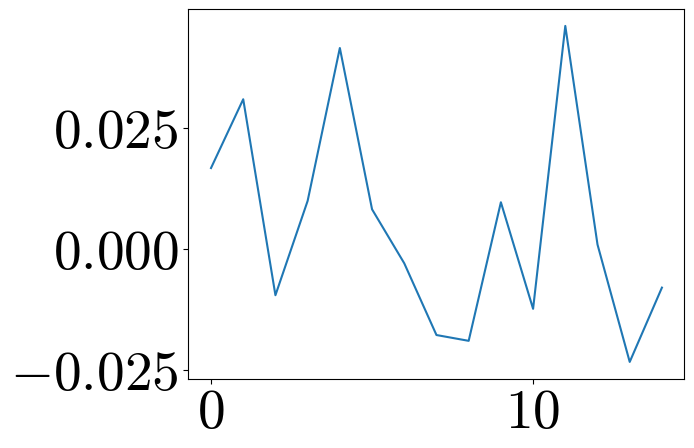

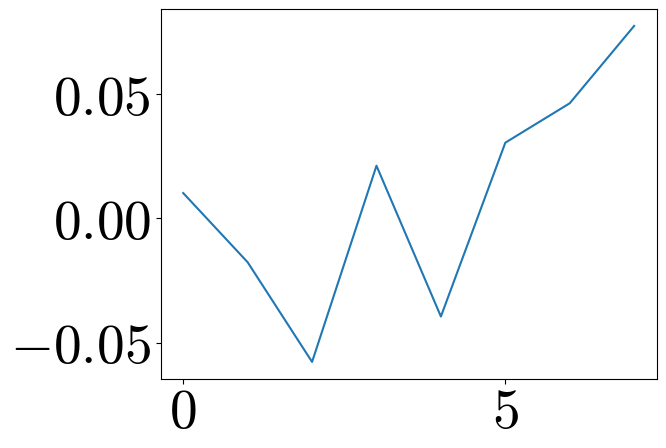

In [101]:
plt.plot(np.nansum(intensity_ds_norm[:, 35:50], axis=0))
plt.show()
plt.plot(np.nansum(intensity_ds_norm[:, 35:50], axis=1))
plt.show()

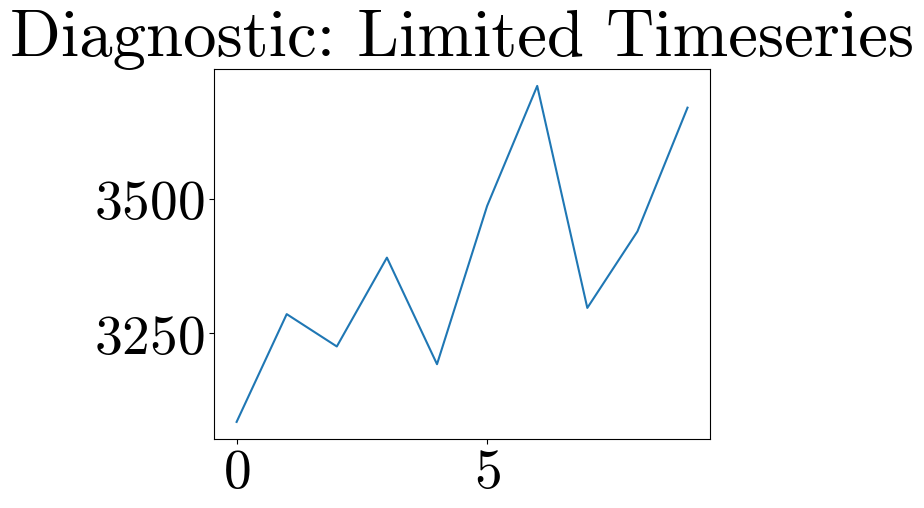

100%|██████████| 1024/1024 [00:00<00:00, 29748.69it/s]


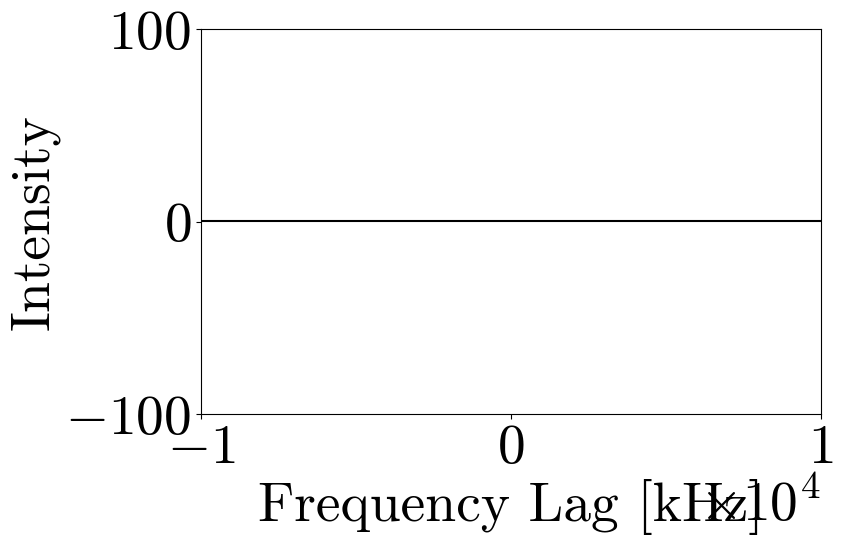

In [102]:
#for i in np.arange(0, 3):
#spec_norm = spectrum / np.max(spectrum)
intensity_tshape = intensity.shape[1]
intensity_off = intensity[:, 35:50]
offspec_mean = np.nanmean(intensity_off)
outer_bound = 5
spectrum_lim = np.nansum(intensity[:, intensity_tshape//2 - outer_bound:intensity_tshape//2 + outer_bound], axis=1)

fig = plt.figure()
plt.plot(np.nansum(intensity[:, intensity_tshape//2 - outer_bound:intensity_tshape//2 + outer_bound], axis=0))
plt.title('Diagnostic: Limited Timeseries')
plt.show()

spec_norm = spectrum_lim #/ np.max(spectrum_lim)
acf=sct.autocorr(spec_norm, offspec_mean = offspec_mean)
lags=np.arange(len(acf))+1
acf=acf[1:]
lags=lags[1:]
acf=np.concatenate((acf[::-1],acf))
lags=np.concatenate((-1*lags[::-1],lags))*fres_kHz

lag_range_for_fit=200 #somewhat arbitrary, 2000 works well to successfully fit the central peak

#gmodel = Model(sct.doublelorentz)
acf_for_fit = acf[int(len(acf)/2.)-int(lag_range_for_fit/fres_kHz):int(len(acf)/2.)+int(lag_range_for_fit/fres_kHz)]
lags_for_fit = lags[int(len(acf)/2.)-int(lag_range_for_fit/fres_kHz):int(len(acf)/2.)+int(lag_range_for_fit/fres_kHz)]
#result = gmodel.fit(acf_for_fit, x=lags_for_fit, gamma1=10, m1=1,gamma2=100,m2=1, c=0)
#result = gmodel.fit(acf_for_fit, x=lags_for_fit, gamma1=1, m1=1,c=0)
#print(result.fit_report())

fig = plt.figure(figsize = (8, 5))

ax = plt.gca()
ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.xaxis.get_major_formatter().set_scientific(True)
ax.xaxis.get_major_formatter().set_powerlimits((-4, 4))

#label_str = r'$\mathcal{L}(\Delta \nu =$ ' + str(round(result.params['gamma1'].value)) + r' $\pm$ ' + str(round(result.params['gamma1'].stderr)) + ' kHz)'


plt.step(lags, acf, c = 'k')
#plt.plot(lags, sct.lorentz(lags, result.params['gamma1'], result.params['m1'], result.params['c']), c = 'm', lw = 3, label = label_str)
#plt.plot(lags, acf - sct.lorentz(lags, result.params['gamma1'], result.params['m1'], result.params['c']) - 0.1, c = 'm', alpha = 0.3, lw = 3)

plt.xlim(-10e3, 10e3)
plt.ylim(-100, 100)
plt.xlabel('Frequency Lag [kHz]')
plt.ylabel('Intensity')
#plt.legend()
#fig.savefig(f'/media/ubuntu/ssd/jfaber/dsa110-scat/codetections/figures/{name.split("_")[0]}/{name}_chime_acf_fit.pdf', bbox_inches = 'tight')
plt.show()

$L_x L_g \lesssim \frac{D_s^2}{2 \pi \nu^2(1+z)} \frac{\nu_{\mathrm{DC}}}{t_{\text {scatt }}}$.

In [103]:
def Lx(nu, dso, z, sbw, tau, Lg):
    lx = (dso**2 * sbw) / (Lg * (2 * np.pi * nu**2) * (1+z) * tau)
    return lx

with open(f'/arc/home/jfaber/baseband_morphologies/chime_dsa_codetections/localizations/dsa_localizations.json', 'r') as file:
    loc_data = json.load(file)

#localization = ['20h50m28.59s', '+73d54m00.0s']
#z_source = 0.0740
localization = [loc_data[f'{name.split("_")[0]}']["localization"]["ra"], loc_data[f'{name.split("_")[0]}']["localization"]["dec"]]
#z_source = loc_data[f'{name.split("_")[0]}']["z_source"]
z_source = 0.239 # corresponds to a comoving distance of 1 Gpc
print('localization:', localization)
print('z_source:', z_source)

gal_dist = 30 #kpc
coord_icrs = SkyCoord(localization[0], localization[1], frame = 'icrs')
coord_galactic = coord_icrs.galactic
ra_gal_deg = coord_galactic.l.deg
dec_gal_deg = coord_galactic.b.deg
output = get_dm_full(ra_gal_deg, dec_gal_deg, gal_dist)

print('NE2001 Sightline Estimates:')
print('________________________________')
ne2001_sbw_1p4GHz = output["SBW"]*(1.4)**best_fit_params_dict["alpha"]
print(f'SBW (1.4 GHz): {1e3*ne2001_sbw_1p4GHz} kHz')
ne2001_tau_1p4GHz = output["TAU"]*(1.4)**(-1 * best_fit_params_dict["alpha"])
print(f'Tau (1.4 GHz): {ne2001_tau_1p4GHz} ms')
print('\n')

# Perform two-screen calculation
print('Two Screen Analysis:')
print('________________________________')
# Define a cosmology, e.g., H0 = 70 km/s/Mpc and Omega_m = 0.3
H0 = 70
Om0 = 0.3
cosmo = FlatLambdaCDM(H0=H0, Om0=Om0)
dso = cosmo.comoving_distance(z_source).to(u.kpc) # comoving distance
#dso = 1*u.Gpc
#print(f'Comoving Distance to Source: {dso}')
#sbw_1p4GHz = result.params['gamma1'].value * u.kHz
#print(f'Measured SBW (1.4 GHz): {sbw_1p4GHz}')
nu = (1.4 * u.GHz).to(u.kHz)
print(f'Observing Frequency: {nu}')
tau_1p4GHz = best_fit_params_dict['tau_1GHz'][0] * 1.4**(-1*best_fit_params_dict['alpha']) * u.ms
print(f'Measured Tau (1.4 GHz): {tau_1p4GHz}')
#lg = 1 * u.kpc
#print(f'L_g (MW Thick Disk): {lg}')
#lx = Lx(nu, dso, z_source, sbw_1p4GHz, tau_1p4GHz, lg)
#lx_kpc = lx.to(u.kpc)
#print(f'Upper Limit on Source-to-Screen Distance: {lx_kpc}')



localization: ['11h19m56.05s', '+70d40m34.4s']
z_source: 0.239
NE2001 Sightline Estimates:
________________________________
SBW (1.4 GHz): 4709.801599999999 kHz
Tau (1.4 GHz): 3.9202415660141616e-05 ms


Two Screen Analysis:
________________________________
Observing Frequency: 1400000.0 kHz
Measured Tau (1.4 GHz): 0.2642585552394007 ms


In [104]:
two_screen_dict = {}
two_screen_dict["localization"] = localization
two_screen_dict["z_source"] = z_source
two_screen_dict["cosmology"] = [H0, Om0]
two_screen_dict["comoving_distance"] = dso.value
two_screen_dict["ra_gal"] = ra_gal_deg
two_screen_dict["dec_gal"] = dec_gal_deg
two_screen_dict["ne2001_fulldict"] = output
two_screen_dict["ne2001_sbw_1.4GHz"] = ne2001_sbw_1p4GHz
two_screen_dict["ne2001_tau_1.4GHz"] = ne2001_tau_1p4GHz
#two_screen_dict["sbw_1.4GHz"] = sbw_1p4GHz.value
two_screen_dict["tau_1.4GHz"] = tau_1p4GHz.value
#two_screen_dict["L_G"] = lg.value
#two_screen_dict["L_X"] = lx_kpc.value

best_fit_params_dict["two_screen"] = two_screen_dict


In [108]:
print(best_fit_params_dict)

{'c0': (0.002117142072900919, 3.4950540293106e-06, -5.096020718971684e-06), 't0': (3.31205908642937, 0.00042011817178089217, -0.00027171061936570595), 'spectral_index': (-14.441152765545334, 0.03524186173092403, -0.026494606502131646), 'zeta': (0.0729023999329778, 0.0004358734784513374, -0.0003257676938700216), 'tau_1GHz': (1.0151756658076816, 0.0032375336938927912, -0.006978058443617208), 'alpha': 4.0, 'initial_params': {'c0_init': 58.246666, 't0_init': 3.41504, 'gamma_init': -10, 'zeta_init': 0.05, 'tau_init': 1.4}, 'prior_bounds': {'c0': (0, 0.05), 't0': (3.2, 3.35), 'spectral_index': (-15, -11), 'zeta': (0.06, 0.9), 'tau_1GHz': (0.85, 1.1)}, 'two_screen': {'localization': ['11h19m56.05s', '+70d40m34.4s'], 'z_source': 0.239, 'cosmology': [70, 0.3], 'comoving_distance': 966471.5290736307, 'ra_gal': 133.33265375633513, 'dec_gal': 44.55831358184823, 'ne2001_fulldict': {'LOWERLIM': False, 'DIST': 30.0, 'DM': 37.9736, 'DMz': 26.6436, 'SM': 0.0002307, 'SMtau': 3.541e-05, 'SMtheta': 0.0006

In [110]:

with open(f'/arc/home/jfaber/baseband_morphologies/chime_dsa_codetections/scattering/{name.split("_")[0]}_best_fit_params.json', 'w') as f:
    json.dump(best_fit_params_dict, f,
              default=lambda o: o.item() if isinstance(o, np.generic)
                               else o.tolist() if hasattr(o, 'tolist')
                               else None,
              indent=2)